# <span style="color:#006600">PROJET 7: IMPLEMENTEZ UN MODELE DE SCORING</span>

## <span style="color:#006600">1- Compréhension de la probématique</span>

#### <span style="color:#39ac39">Contexte</span>

**Prêt à depenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. La vision de cette entreprise est de mettre en oeuvre un outil de "**scoring crédit**" pour calculer la probabilité qu'un client rembourse son crédit, pui classifie la demande en crédit accordé ou refusé. A cet, l'idée est donc de développer un **algorithme de classification** en s'appuyant sur des données sources de données variées (données comportementales, données provenant d'autres institutions financières, etc). 

Toujours dans cette même vision, les chargés de relation client on fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décision d'octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l'entreprise veut encarner.

A cet problèmatique, il est alors question de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décision d'aoctroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

#### <span style="color:#39ac39">Objectifs de la mission</span>

1- Construire un modèle de scoring qui donnera une prédiction sur la probalibilité de faillite d'un client de façon automatique
2- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interprèter les prédictions faites par le modèle, et d'améliorer la connaissance client des chargés de relation client.

Pour faciliter la préparation des données nécessaires à l'élaboration du modèle de scoring, il est demandé de sélectionner un kernet Kaggle. Ce kernet sera analysé et adapté pour s'aasurer qu'il répond aux bésoins de la mission.

#### <span style="color:#39ac39">Spécifications du dashaboard</span>

Il doit contenir au minimum les donctionnalités suivantes:

* Permettre de visualiser le score et l'interprètation de ce score pour chaque client de façon intelligible pour une personne non exdperte en data science

* Permettre de visualiser les informations descriptives relatives à un client (via un système de filtre)

* Permettre de comparer les informations descriptives relatives à un client à l'ensemble des clients ou à un groupe de clients similaires.

#### <span style="color:#39ac39">Livrables</span>

1- Le **dashboard** interactif répondant aux spécifications ci-dessus et l'API de prédiction du score, déployées chacunes sur le cloud

2- Le dossier sur un outil de versionning de code contenant:

* Le code de la modélisation d'entraînement (du prétraitement à la prédiction)
* Le code générant le dashboard
* Le code permettant de déployer le modèle sous forme d'API

3- Une **mote méthodologique** décrivant:

* La méthodologie d'entraînement du modèle (2 pages maximum)
* La fonction coût métier, l'algorithme d'optimisation et la métriqiue d'évaluation (1 page)
* L'interprétabilité globale et locale du modèle (1 page maximum)
* Les limites et les amélioration possibles (1 pages maximum)

4- Une **support de présentation** pour la soutenance, détaillant le travailréalisé

## <span style="color:#006600">2- Importation des packages et des données</span>

#### <span style="color:#39ac39">2-1 Importation des packages</span>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
import os
import glob

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [98]:
#Graphing…
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

font_title = {"family": "serif",
              "weight": "bold",
              "size": 25}

In [62]:
display(os.listdir('./dataSet_Projet_07/'))

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

#### <span style="color:#39ac39">2-2 Lecture des données différents fichiers de données</span>

In [63]:
%%time 
application_train = pd.read_csv('dataSet_Projet_07/application_train.csv').sort_values("SK_ID_CURR")
application_test = pd.read_csv('dataSet_Projet_07/application_test.csv').sort_values("SK_ID_CURR")
bureau = pd.read_csv('dataSet_Projet_07/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau_balance = pd.read_csv('dataSet_Projet_07/bureau_balance.csv').sort_values("SK_ID_BUREAU")
credit_card_balance = pd.read_csv('dataSet_Projet_07/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
installments_payments = pd.read_csv('dataSet_Projet_07/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
POS_CASH_balance = pd.read_csv('dataSet_Projet_07/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
previous_application = pd.read_csv('dataSet_Projet_07/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])

Wall time: 1min 28s


In [64]:
description = pd.read_csv('Data_description/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description.head(5)

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

**application_{train|test}.csv**

Il s'agit du fichier de données principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Ce fichier de données comporte les données statistiques pour toutes les demandes. Une ligne représente un prêt dans l'échantillon de données.

**bureau.csv**

Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au Bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).

Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

**bureau_balance.csv**

Soldes mensuels des crédits précédents dans le Credit Bureau.

Ce fichier de données comporte une ligne pour chaque mois de l'historique de chaque crédit précédent rapporté au Credit Bureau - c'est-à-dire que le fichier comporte (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) des lignes.

**POS_CASH_balance.csv**

Des instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eus avec Home Credit.

Ce fichier comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.

**credit_card_balance.csv**

Des instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède auprès de Home Credit.

Ce fichier comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) des lignes.

**previous_application.csv**

Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon.

Il existe une ligne pour chaque demande antérieure liée à des prêts dans notre échantillon de données.

**installments_payments.csv**

L'historique des remboursements pour les crédits précédemment déboursés dans Home Credit et liés aux prêts de notre échantillon. Il y a:
* une ligne pour chaque paiement effectué et 
* une ligne pour chaque paiement manqué.

Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit immobilier précédent lié aux prêts de notre échantillon.

**HomeCredit_columns_description.csv**

Ce fichier contient les descriptions des colonnes des différents fichiers de données.

#### <span style="color:#39ac39">2-1 Description des différents fichiers de données</span>

Affichons la description détaillée du contenu de chaque fichier de données. Pour ce fait, nous allons définir une fonction qui permettra de vérifier le nombre de lignes, de colonnes, des valeurs manquantes, des doublons, le comptage du type de colonnes dans chaque fichier de données téléchargés.

In [65]:
def description_data(dossier_data):
    '''Vérifiez le nombre de lignes, de colonnes, de valeurs manquantes et de doublons.
       Comptez le type de colonnes'''

    data_dict = {}
    for file in dossier_data:
        data = pd.read_csv(file)
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1]]

        comparative_data = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Nbr ligne', 'Nbr colonne', '%NaN', '%Doublon', 
                                                              'object_dtype','float_dtype', 'int_dtype', 
                                                              'bool_dtype'], 
                                                   orient='index')
    print("FICHIERS DE RÉSUMÉ…")
    return(comparative_data)

In [66]:
#Description des données
description_data(dossier_data = glob.glob('./dataSet_Projet_07/*.csv'))

FICHIERS DE RÉSUMÉ…


Nbr ligne  Nbr colonne   %NaN  \
./dataSet_Projet_07\application_test.csv           48744          121  23.81   
./dataSet_Projet_07\application_train.csv         307511          122  24.40   
./dataSet_Projet_07\bureau.csv                   1716428           17  13.50   
./dataSet_Projet_07\bureau_balance.csv          27299925            3   0.00   
./dataSet_Projet_07\credit_card_balance.csv      3840312           23   6.65   
./dataSet_Projet_07\installments_payments.csv   13605401            8   0.01   
./dataSet_Projet_07\POS_CASH_balance.csv        10001358            8   0.07   
./dataSet_Projet_07\previous_application.csv     1670214           37  17.98   
./dataSet_Projet_07\sample_submission.csv          48744            2   0.00   

                                               %Doublon  object_dtype  \
./dataSet_Projet_07\application_test.csv            0.0            16   
./dataSet_Projet_07\application_train.csv           0.0            16   
./dataSet_Projet_07\bureau.csv                      0.0             3   
./dataSet_Projet_07\bureau_balance.csv              0.0             1   
./dataSet_Projet_07\credit_card_balance.csv         0.0             1   
./dataSet_Projet_07\installments_payments.csv       0.0             0   
./dataSet_Projet_07\POS_CASH_balance.csv            0.0             1   
./dataSet_Projet_07\previous_application.csv        0.0            16   
./dataSet_Projet_07\sample_submission.csv           0.0             0   

                                               float_dtype  int_dtype  \
./dataSet_Projet_07\application_test.csv                65          0   
./dataSet_Projet_07\application_train.csv               65          0   
./dataSet_Projet_07\bureau.csv                           8          0   
./dataSet_Projet_07\bureau_balance.csv                   0          0   
./dataSet_Projet_07\credit_card_balance.csv             15          0   
./dataSet_Projet_07\installments_payments.csv            5          0   
./dataSet_Projet_07\POS_CASH_balance.csv                 2          0   
./dataSet_Projet_07\previous_application.csv            15          0   
./dataSet_Projet_07\sample_submission.csv                1          0   

                                               bool_dtype  
./dataSet_Projet_07\application_test.csv                0  
./dataSet_Projet_07\application_train.csv               0  
./dataSet_Projet_07\bureau.csv                          0  
./dataSet_Projet_07\bureau_balance.csv                  0  
./dataSet_Projet_07\credit_card_balance.csv             0  
./dataSet_Projet_07\installments_payments.csv           0  
./dataSet_Projet_07\POS_CASH_balance.csv                0  
./dataSet_Projet_07\previous_application.csv            0  
./dataSet_Projet_07\sample_submission.csv               0

#### <span style="color:#39ac39">2-2 Description du contenu de chaque colonne des différents fichiers de données</span>

In [67]:
def description_features(dossier_data):
    '''Données comparatives avec valeurs manquantes, et 
    de nombreuses statistiques descriptives.'''
    
    data_object = {}
    data_numeric = {}
    
    for file in dossier_data:
        data = pd.read_csv(file)
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2

In [68]:
#Description des colonnes catégorielles de chaque fichier de données
description_features(dossier_data=glob.glob('./dataSet_Projet_07/*.csv'))[0]

features  \
./dataSet_Projet_07\application_test.csv      0                    SK_ID_CURR   
                                              1            NAME_CONTRACT_TYPE   
                                              2                   CODE_GENDER   
                                              3                  FLAG_OWN_CAR   
                                              4               FLAG_OWN_REALTY   
                                              5                  CNT_CHILDREN   
                                              6               NAME_TYPE_SUITE   
                                              7              NAME_INCOME_TYPE   
                                              8           NAME_EDUCATION_TYPE   
                                              9            NAME_FAMILY_STATUS   
                                              10            NAME_HOUSING_TYPE   
                                              11                   DAYS_BIRTH   
                                              12                DAYS_EMPLOYED   
                                              13              DAYS_ID_PUBLISH   
                                              14                   FLAG_MOBIL   
                                              15               FLAG_EMP_PHONE   
                                              16              FLAG_WORK_PHONE   
                                              17             FLAG_CONT_MOBILE   
                                              18                   FLAG_PHONE   
                                              19                   FLAG_EMAIL   
                                              20              OCCUPATION_TYPE   
                                              21         REGION_RATING_CLIENT   
                                              22  REGION_RATING_CLIENT_W_CITY   
                                              23   WEEKDAY_APPR_PROCESS_START   
                                              24      HOUR_APPR_PROCESS_START   
                                              25   REG_REGION_NOT_LIVE_REGION   
                                              26   REG_REGION_NOT_WORK_REGION   
                                              27  LIVE_REGION_NOT_WORK_REGION   
                                              28       REG_CITY_NOT_LIVE_CITY   
                                              29       REG_CITY_NOT_WORK_CITY   
                                              30      LIVE_CITY_NOT_WORK_CITY   
                                              31            ORGANIZATION_TYPE   
                                              32           FONDKAPREMONT_MODE   
                                              33               HOUSETYPE_MODE   
                                              34           WALLSMATERIAL_MODE   
                                              35          EMERGENCYSTATE_MODE   
                                              36              FLAG_DOCUMENT_2   
                                              37              FLAG_DOCUMENT_3   
                                              38              FLAG_DOCUMENT_4   
                                              39              FLAG_DOCUMENT_5   
                                              40              FLAG_DOCUMENT_6   
                                              41              FLAG_DOCUMENT_7   
                                              42              FLAG_DOCUMENT_8   
                                              43              FLAG_DOCUMENT_9   
                                              44             FLAG_DOCUMENT_10   
                                              45             FLAG_DOCUMENT_11   
                                              46             FLAG_DOCUMENT_12   
                                              47             FLAG_DOCUMENT_13   
                                              48             FLAG_DOCUMENT_14   
                   

In [69]:
#Description des colonnes numérique de chaque fichier de données
description_features(dossier_data=glob.glob('./dataSet_Projet_07/*.csv'))[1]

features  \
./dataSet_Projet_07\application_test.csv      0                      SK_ID_CURR   
                                              1                    CNT_CHILDREN   
                                              2                AMT_INCOME_TOTAL   
                                              3                      AMT_CREDIT   
                                              4                     AMT_ANNUITY   
                                              5                 AMT_GOODS_PRICE   
                                              6      REGION_POPULATION_RELATIVE   
                                              7                      DAYS_BIRTH   
                                              8                   DAYS_EMPLOYED   
                                              9               DAYS_REGISTRATION   
                                              10                DAYS_ID_PUBLISH   
                                              11                    OWN_CAR_AGE   
                                              12                     FLAG_MOBIL   
                                              13                 FLAG_EMP_PHONE   
                                              14                FLAG_WORK_PHONE   
                                              15               FLAG_CONT_MOBILE   
                                              16                     FLAG_PHONE   
                                              17                     FLAG_EMAIL   
                                              18                CNT_FAM_MEMBERS   
                                              19           REGION_RATING_CLIENT   
                                              20    REGION_RATING_CLIENT_W_CITY   
                                              21        HOUR_APPR_PROCESS_START   
                                              22     REG_REGION_NOT_LIVE_REGION   
                                              23     REG_REGION_NOT_WORK_REGION   
                                              24    LIVE_REGION_NOT_WORK_REGION   
                                              25         REG_CITY_NOT_LIVE_CITY   
                                              26         REG_CITY_NOT_WORK_CITY   
                                              27        LIVE_CITY_NOT_WORK_CITY   
                                              28                   EXT_SOURCE_1   
                                              29                   EXT_SOURCE_2   
                                              30                   EXT_SOURCE_3   
                                              31                 APARTMENTS_AVG   
                                              32               BASEMENTAREA_AVG   
                                              33    YEARS_BEGINEXPLUATATION_AVG   
                                              34                YEARS_BUILD_AVG   
                                              35                 COMMONAREA_AVG   
                                              36                  ELEVATORS_AVG   
                                              37                  ENTRANCES_AVG   
                                              38                  FLOORSMAX_AVG   
                                              39                  FLOORSMIN_AVG   
                                              40                   LANDAREA_AVG   
                                              41           LIVINGAPARTMENTS_AVG   
                                              42                 LIVINGAREA_AVG   
                                              43        NONLIVINGAPARTMENTS_AVG   
                                              44              NONLIVINGAREA_AVG   
                                              45                APARTMENTS_MODE   
                                              46              BASEMENTAREA_MODE   
                                              47   YEARS_BEGINEXPLUATATION_MODE   
    

#### >>> Variable à prédire "TARGET"

Le nom de la colonne dont on cherche à prédire la valeur est "TARGET". Cette variable prend soit la valeur 0 quand le prêt a été remboursé sans soucis, soit la valeur 1 qiuand il y a eu un defaut de payement.

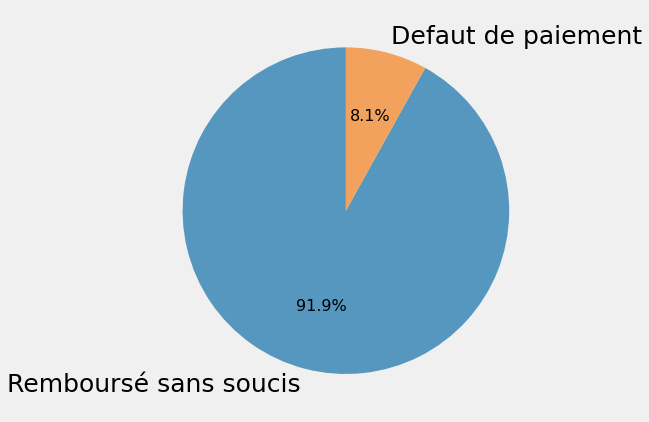

In [70]:
# Plot categories count in dataset
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize = (14, 7))
target_values = application_train['TARGET'].value_counts()/len(application_train)*100
plt.pie(target_values,
            colors=['#5697BF', '#F2A25C'],
            autopct='%1.1f%%',
            labels=["Remboursé sans soucis", "Defaut de paiement"],
            startangle=90)
plt.savefig("fig_01.png")
plt.show()

Dans 91,9% des cas, les prêts ont été remboursés sans soucis et dans 8,1% des cas, on observe un defaut de paiement. On observe sur cette figure des classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps que de prèets non remboursés. Dans la partie modèles d'apprentissage automatique, nous pouvons pondérer les classes par leur représentation dans les données pour rfléter ce déséquilibre.

## <span style="color:#006600">3- Analyse exploratoire des données</span>

Dans cette partie le traitement des features sera basé sur le jeu d'entraÎnement

### <span style="color:#39ac39">3-1 Types de colonnes</span>

#### >>> Quel est le nombre de chaque type de colonnes dans le jeu de données

In [71]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

#### >>> Nombre et le nom des différentes valeurs prises

In [72]:
def display_cat_columns(dataFrame):
    """
    Pour chaque colonne catégorielle, indique le nombre et le nom
    des différentes valeurs prises
    """

    for col in dataFrame:
        if dataFrame[col].dtype == object:
            print(col)
            print('Nombre de classe Unique:', dataFrame[col].nunique())
            print('Unique dans le DataFrame: ',
                  sorted([str(e) for e in
                          dataFrame[col].unique().tolist()]))
            print('\n')

In [73]:
# Descriptif des variables catégorielles
display_cat_columns(application_train)

NAME_CONTRACT_TYPE
Nombre de classe Unique: 2
Unique dans le DataFrame:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Nombre de classe Unique: 3
Unique dans le DataFrame:  ['F', 'M', 'XNA']


FLAG_OWN_CAR
Nombre de classe Unique: 2
Unique dans le DataFrame:  ['N', 'Y']


FLAG_OWN_REALTY
Nombre de classe Unique: 2
Unique dans le DataFrame:  ['N', 'Y']


NAME_TYPE_SUITE
Nombre de classe Unique: 7
Unique dans le DataFrame:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INCOME_TYPE
Nombre de classe Unique: 8
Unique dans le DataFrame:  ['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working']


NAME_EDUCATION_TYPE
Nombre de classe Unique: 5
Unique dans le DataFrame:  ['Academic degree', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Secondary / secondary special']


NAME_FAMILY_STATUS
Nombre de classe Unique: 6
Unique dans le DataFrame:  ['C

La plupart des variables catégorielles ont un nombre relativement petit d'entrées uniques. Nous aurons donc à trouver un moyen pour traiter ces variables catégorielles.

La colonne **'CODE_GENDER'**  dans le jeu de données contient des valeurs nommés 'XNA' pour la colonne renseignant le genre.

La colonne **'NAME_INCOME_TYPE'** prend la valeur 'Maternity leave'.

La colonne **'ORGANIZATION_TYPE'**  dans le jeu de données contient des valeurs nommés 'XNA' pour la colonne renseignant le genre.

### <span style="color:#39ac39">3-2 Données manquantes</span>

A cette étape de l'analyse exploratoire, toutes les données manquantes seront conservées pour le moment.

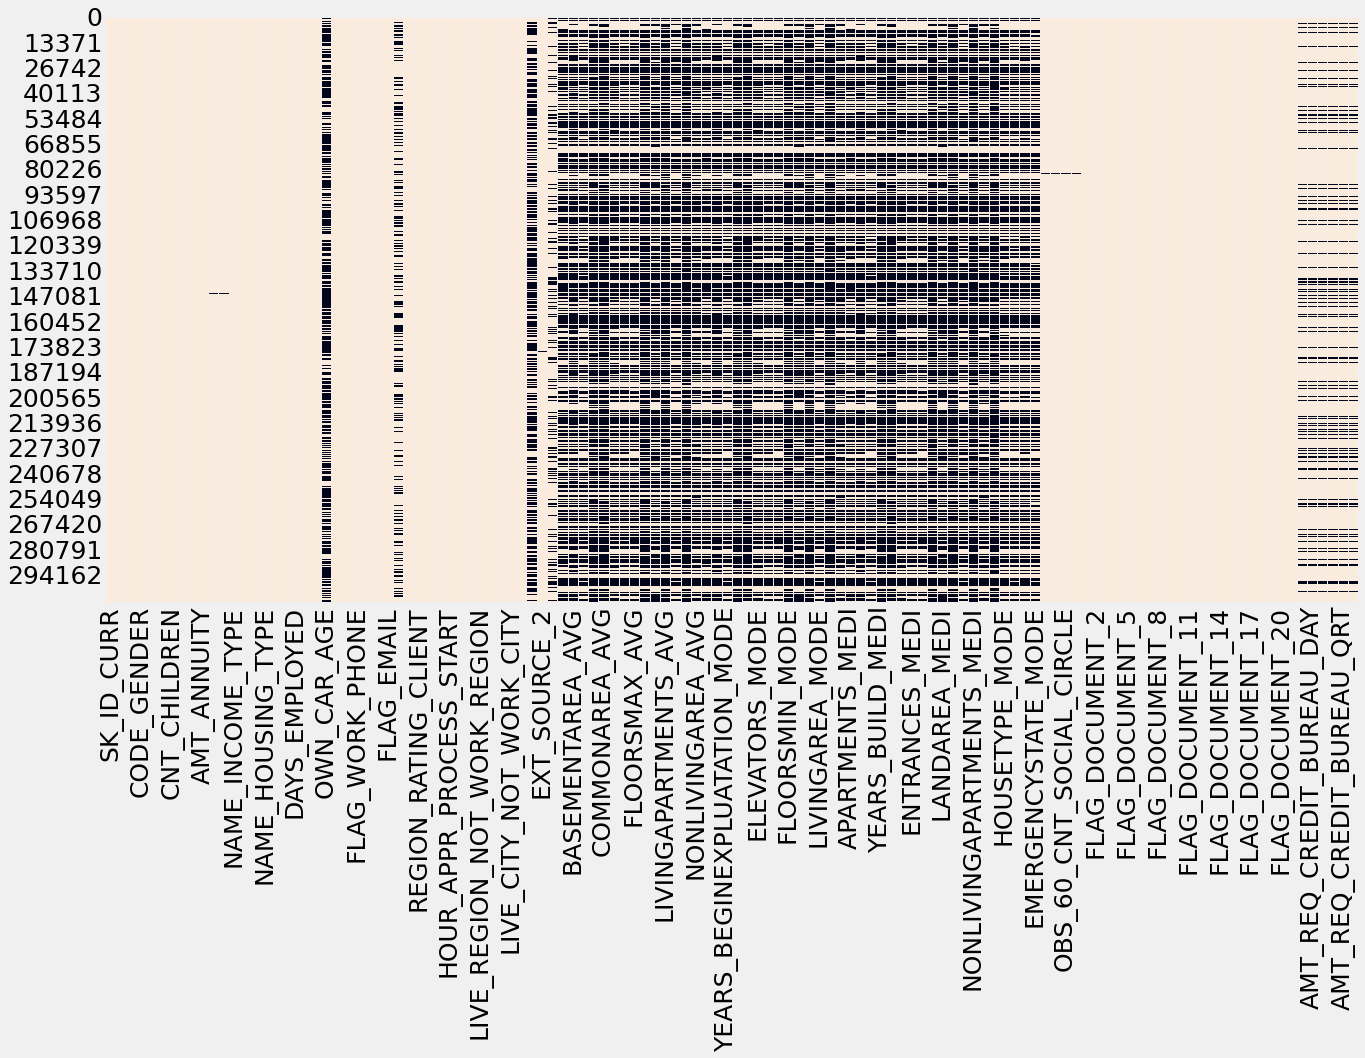

In [74]:
#Vue globale des valeurs manquantes (noir)
plt.figure(figsize=(20,10))
sns.heatmap(application_train.notna(), cbar=False)
plt.savefig("fig_02.png")
plt.show()

In [75]:
#Fonction pour estimer la proportion des valeurs manquantes du jeu de données d'entraînement
def nan_check(data):
    '''Vérifier les valeurs manquantes'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

In [76]:
null_prop = len(nan_check(application_train)[nan_check(application_train)['Total']!=0])/len(nan_check(application_train))*100
print("Le pourcentage de valeurs manquantes est de {:.2f}%".format(null_prop))

Le pourcentage de valeurs manquantes est de 54.92%


In [77]:
print("Propportion des valeurs manquantes par colonne du jeu de données d'entraînement")
nan_check(application_train)[:20]

Propportion des valeurs manquantes par colonne du jeu de données d'entraînement


Total      %
COMMONAREA_MEDI           214865  69.87
COMMONAREA_AVG            214865  69.87
COMMONAREA_MODE           214865  69.87
NONLIVINGAPARTMENTS_MODE  213514  69.43
NONLIVINGAPARTMENTS_AVG   213514  69.43
NONLIVINGAPARTMENTS_MEDI  213514  69.43
FONDKAPREMONT_MODE        210295  68.39
LIVINGAPARTMENTS_MODE     210199  68.35
LIVINGAPARTMENTS_AVG      210199  68.35
LIVINGAPARTMENTS_MEDI     210199  68.35
FLOORSMIN_AVG             208642  67.85
FLOORSMIN_MODE            208642  67.85
FLOORSMIN_MEDI            208642  67.85
YEARS_BUILD_MEDI          204488  66.50
YEARS_BUILD_MODE          204488  66.50
YEARS_BUILD_AVG           204488  66.50
OWN_CAR_AGE               202929  65.99
LANDAREA_MEDI             182590  59.38
LANDAREA_MODE             182590  59.38
LANDAREA_AVG              182590  59.38

Il se dégage de ce tableau que les NaN sont plus fortement présentent sur les caractéristiques des habitats et non sur les crédits, comme l'attest le TOP 10 du tableau ci-dessus.

### <span style="color:#39ac39">3-3 Outliers, valeurs atypiques, anormales</span>

Dans la première partie de ce travail, on avait observé pour les variables 'DAYS_BIRTH' (Jours de naissance) des valeurs négatives. Il est donc important de pouvoir analyser et si besoin corriger ce type de données. Cette obersation est au faite que les données sont enregistrées par rapport à la demande de prêt en cours. Il est donc nécessaire de modifier cette variables pour obtenir des chiffres plus compréhensibles pour la présente analyse.

In [78]:
application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [79]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

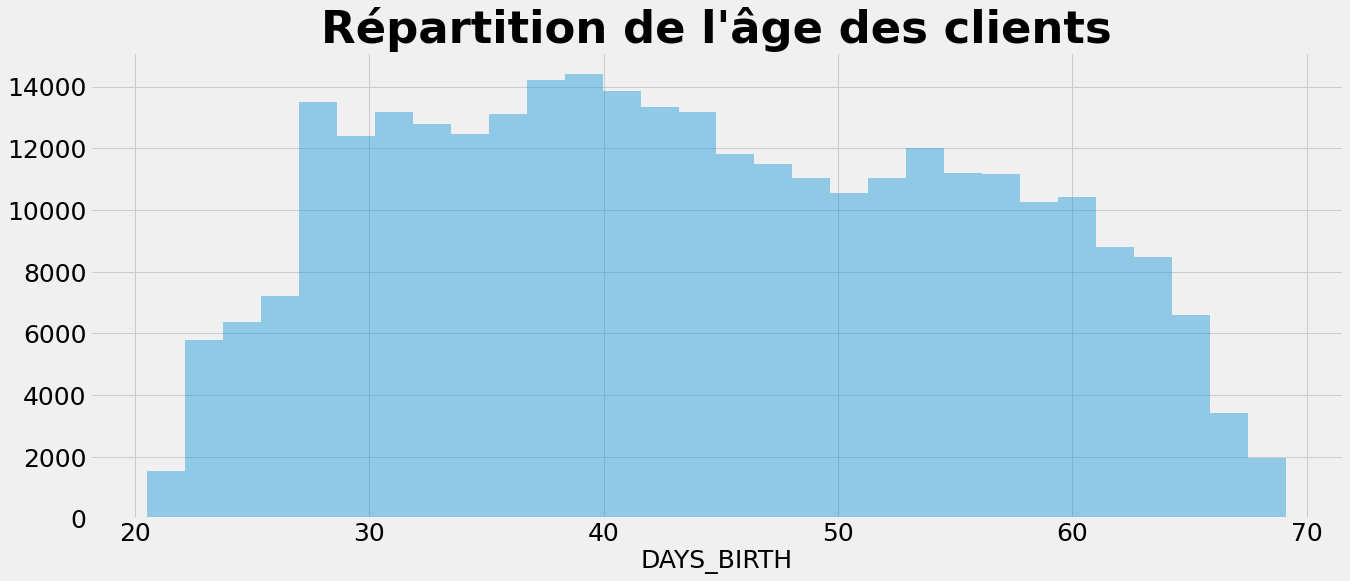

In [80]:
plt.figure(figsize=(20, 8))
sns.distplot((application_train['DAYS_BIRTH'] / -365), bins = 30, kde = False).set_title("Répartition de l'âge des clients")
plt.show()

#### >>> Variable 'DAYS_EMPLOYED'

In [81]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [82]:
print("%0.0f avec 365243 jours employés pour les données d'entraînement" % 
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Valeurs totales des jours employés pour les données d'entraînement" % application_train.shape[0])
print("-----------------------------------------------------------")
print("%0.0f avec 365243 jours employés pour les données test" % 
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Valeurs totales des jours employés pour les données test" % application_test.shape[0])

55374 avec 365243 jours employés pour les données d'entraînement
307511 Valeurs totales des jours employés pour les données d'entraînement
-----------------------------------------------------------
9274 avec 365243 jours employés pour les données test
48744 Valeurs totales des jours employés pour les données test


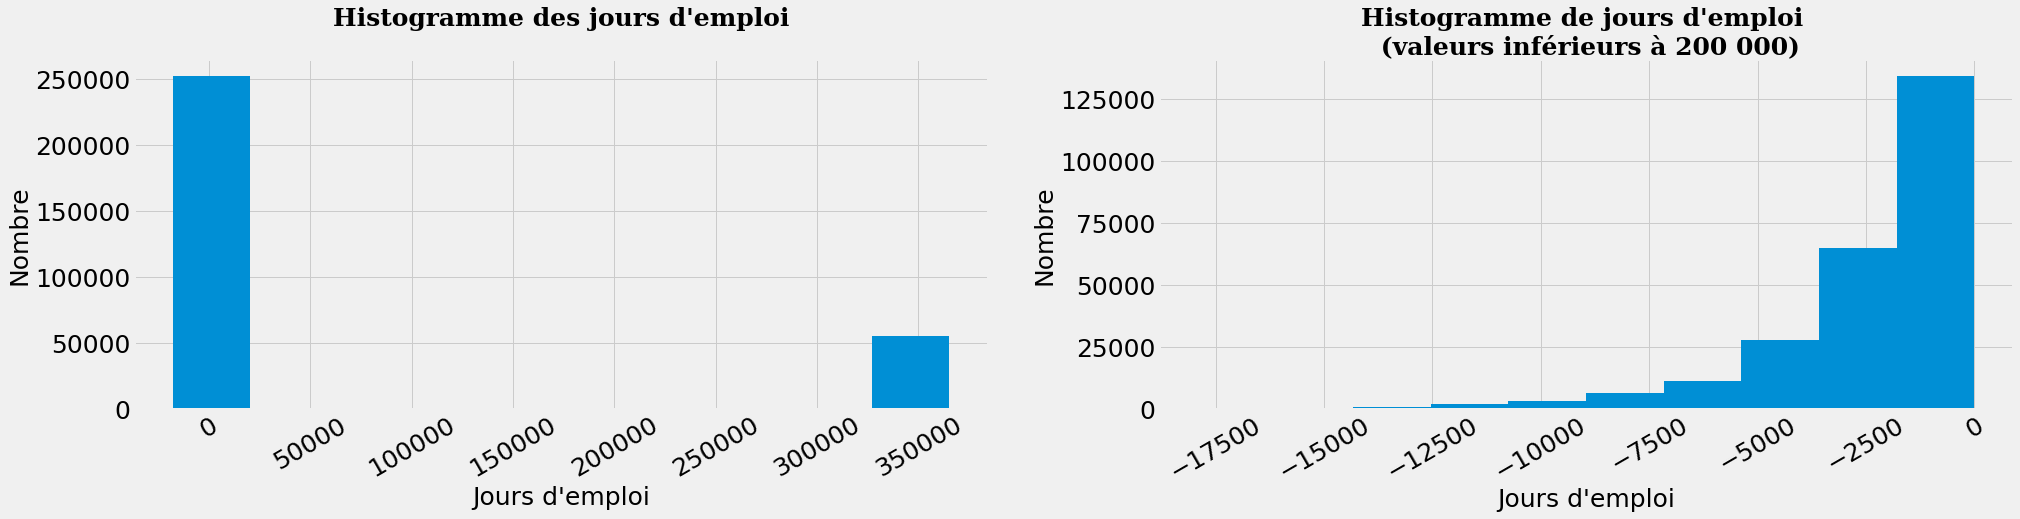

In [100]:
# Affiche l'histogramme du nombre de jours employés
plt.rcParams.update({'font.size': 10})
fig = plt.figure(1, figsize=(30, 6))
plt.subplot(1, 2, 1)
application_train['DAYS_EMPLOYED'].hist()
plt.xlabel("Jours d'emploi")
plt.ylabel('Nombre')
plt.title(f"Histogramme des jours d'emploi\n", fontdict=font_title)
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
application_train.loc[application_train['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.title(f"Histogramme de jours d'emploi \n (valeurs inférieurs à 200 000)", fontdict=font_title)
plt.xlabel("Jours d'emploi")
plt.ylabel('Nombre')
plt.xticks(rotation=30)
plt.show()

Ces données ne sont pas normales au sens où le Max représent 1000 année.

#### >>> Créer une colonne pour les valeurs aberrantes

In [102]:
application_train_copie = application_train.copy()
application_test_copie = application_test.copy()

In [103]:
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

#### >>> Remplacer les valeurs aberrantes par nan

In [35]:
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

### <span style="color:#39ac39">3-4 Fonctions pour faciliter l'analyse des principales variables…</span>

In [196]:
def plot_stat(data, feature, title) : 
    
    plt.figure(figsize=[30,15])
    plt.subplot(121)
    ax = sns.countplot(x=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)
    ax.set_ylabel("Nombre")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
                
    plt.subplot(122)
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax = sns.barplot(x=feature, y='TARGET', data=cat_perc)
    ax.set_title(title + ' '+ "%Target1")
    ax.set_ylabel("Pourcentage de defaut de payement")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

In [200]:
def plot_stat2(data, feature, title) : 
    
    plt.figure(figsize=[30,25])
    plt.subplot(211)
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)
    ax.set_ylabel("Nombre")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
                
    plt.subplot(212)
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title + ' '+ "%Target1")
    ax.set_ylabel("Pourcentage de defaut de payement")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

#### >>> Type de prêts contractés (NAME_CONTRACT_TYPE)

Loan types - Distribution du type de prêts contractés + comparatif avec le pourcentage des prêts avec la valeur TARGET 1(prêt non retourné).

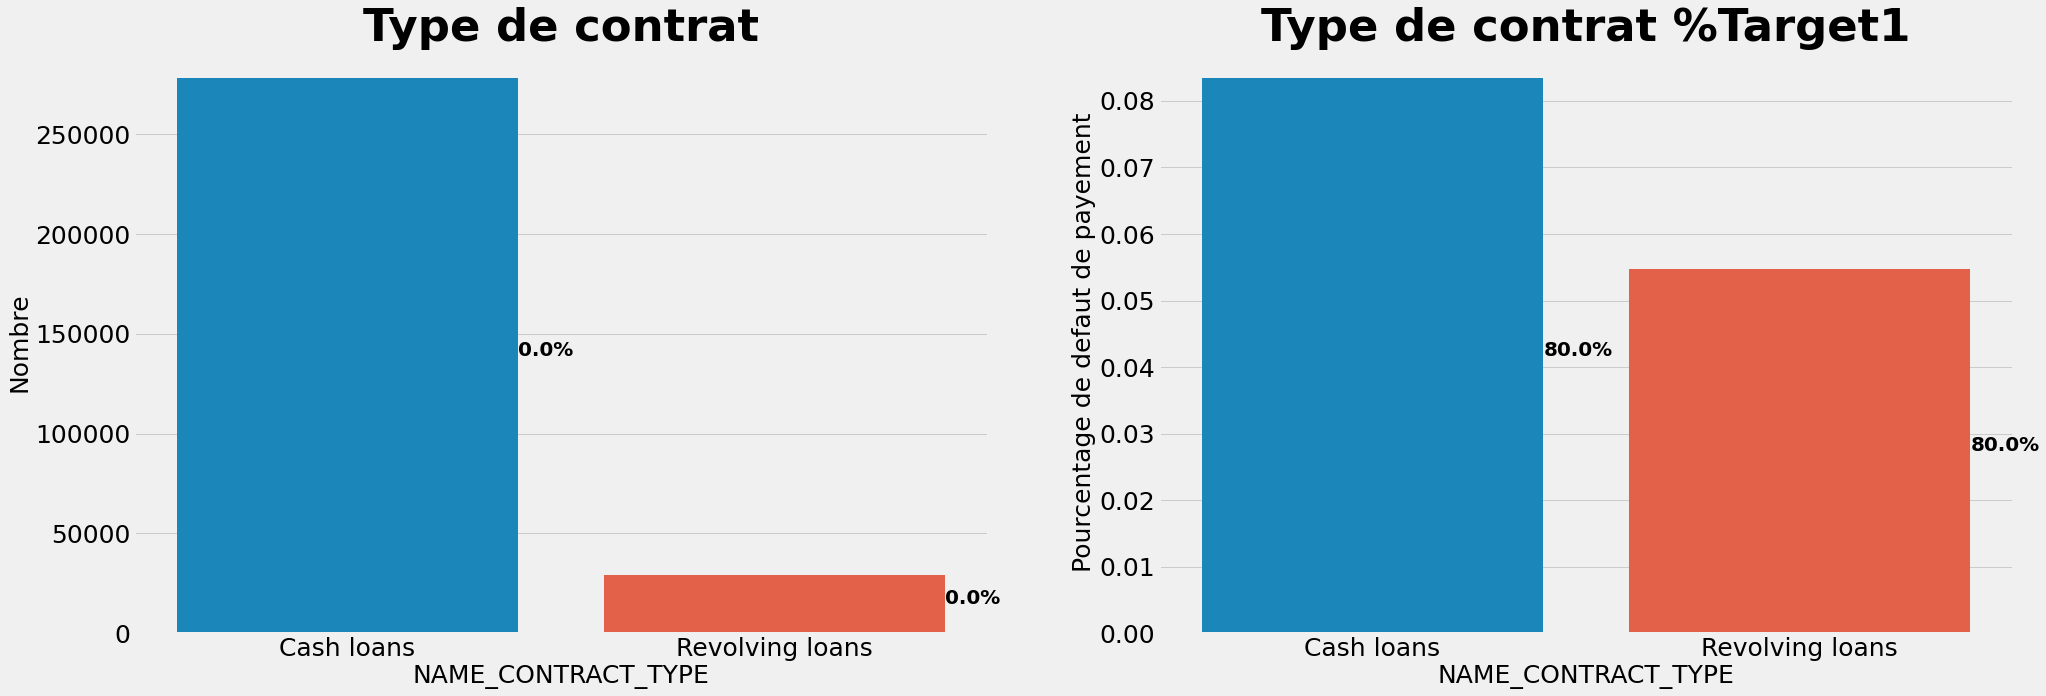

In [157]:
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"Type de contrat")

#### >>> Distribution des clients selon le sexe (H/F) vs % des prêts par sexe  TARGET 1 (prêt non retourné).

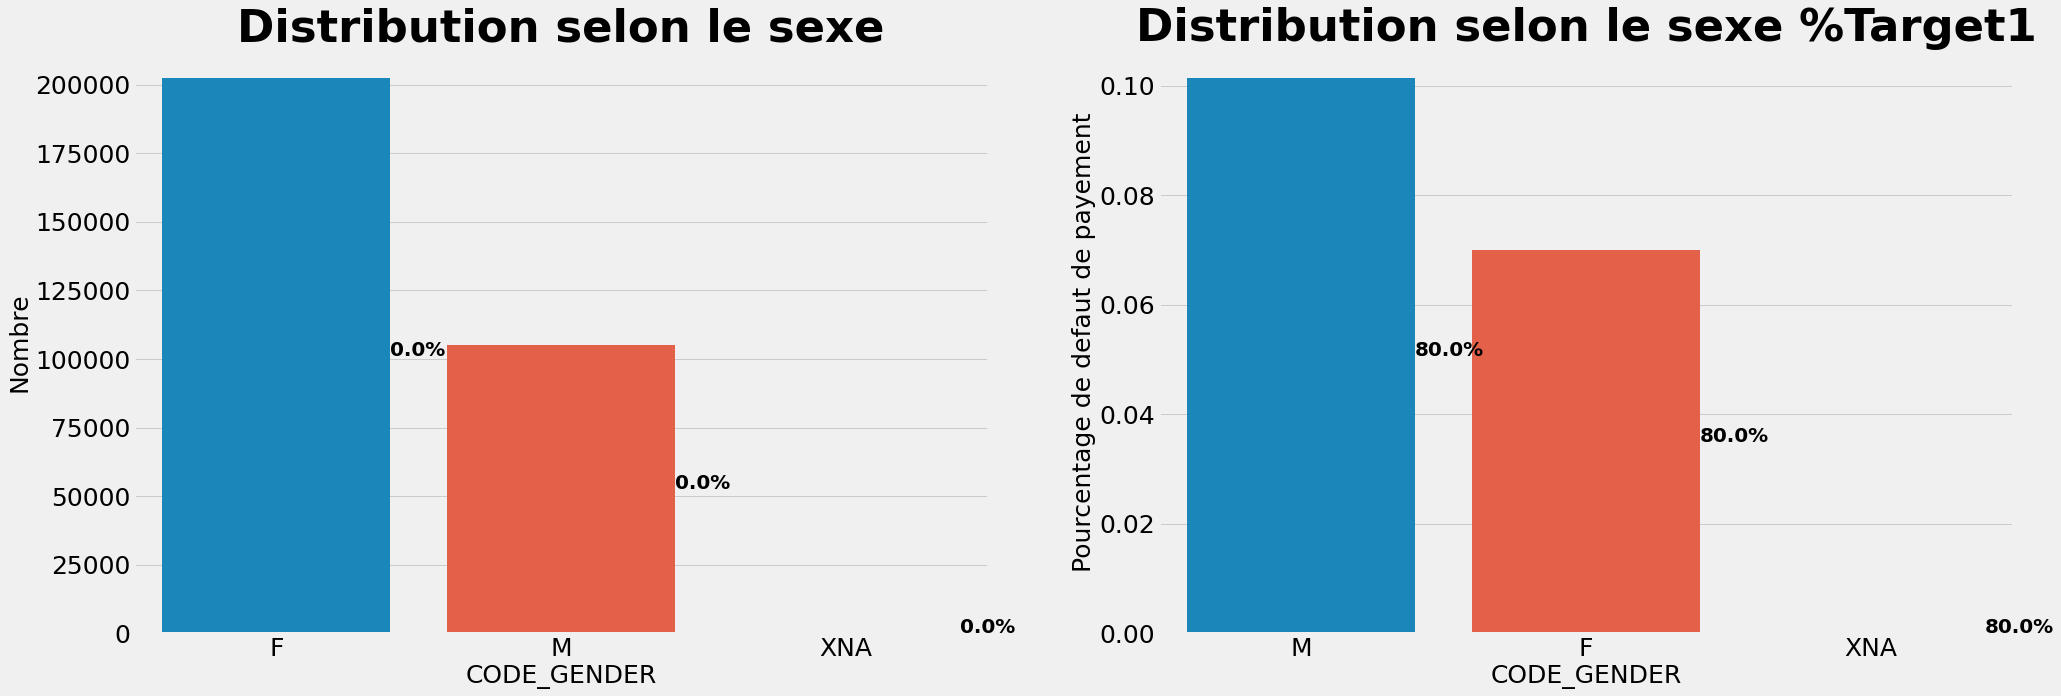

In [153]:
plot_stat(application_train, 'CODE_GENDER',"Distribution selon le sexe")

#### >>> Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas…

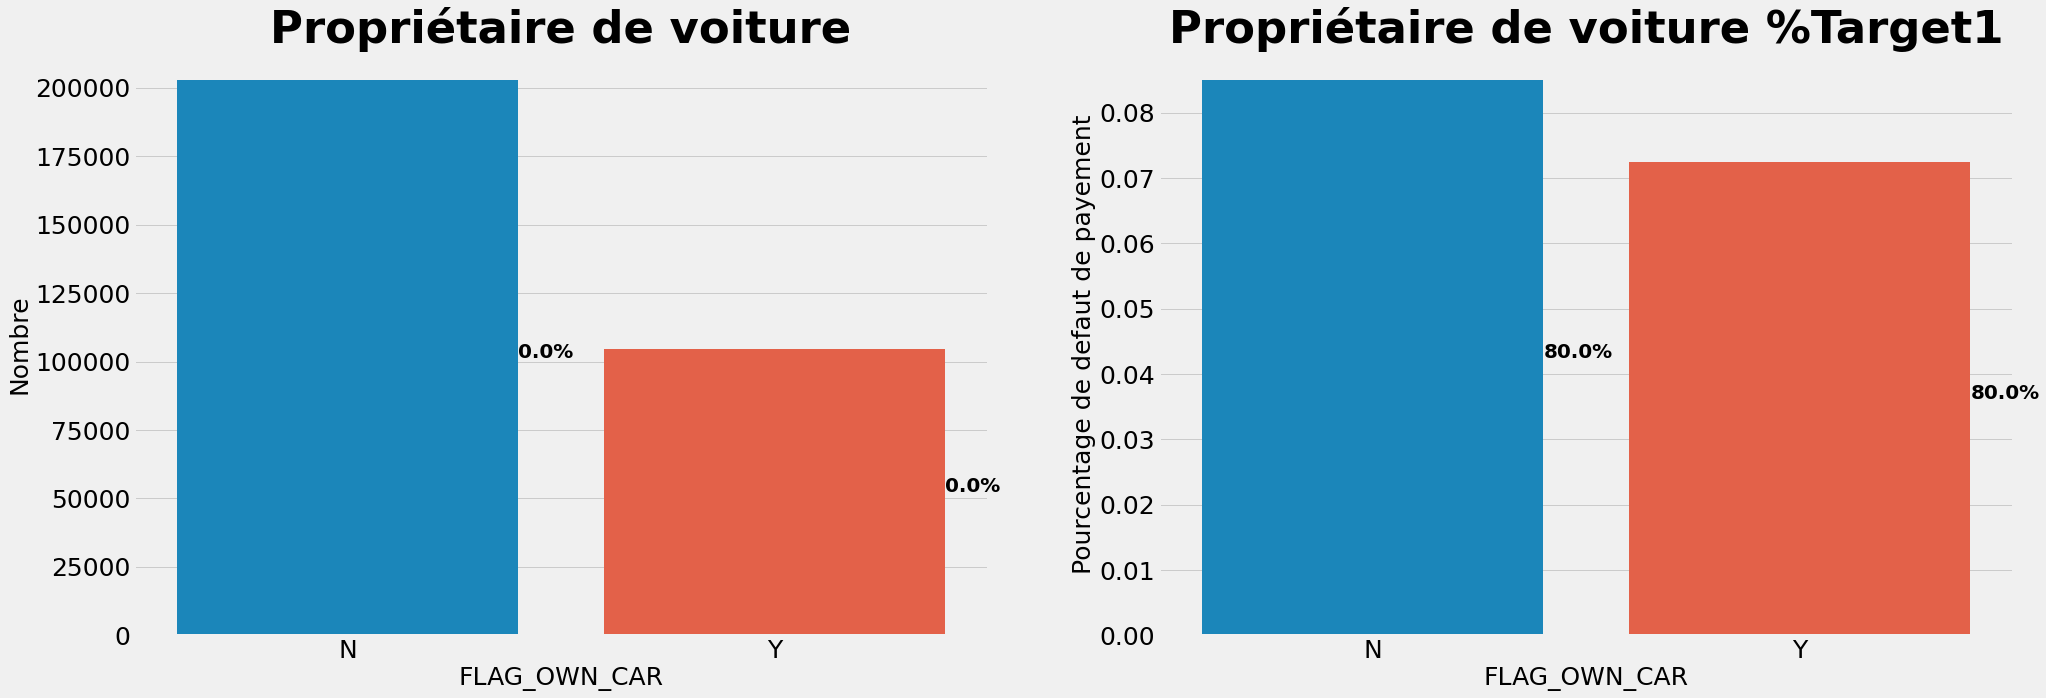

In [158]:
plot_stat(application_train, 'FLAG_OWN_CAR',"Propriétaire de voiture")

#### >>> SITUATION FAMILIALE (NAME_FAMILY_STATUS)

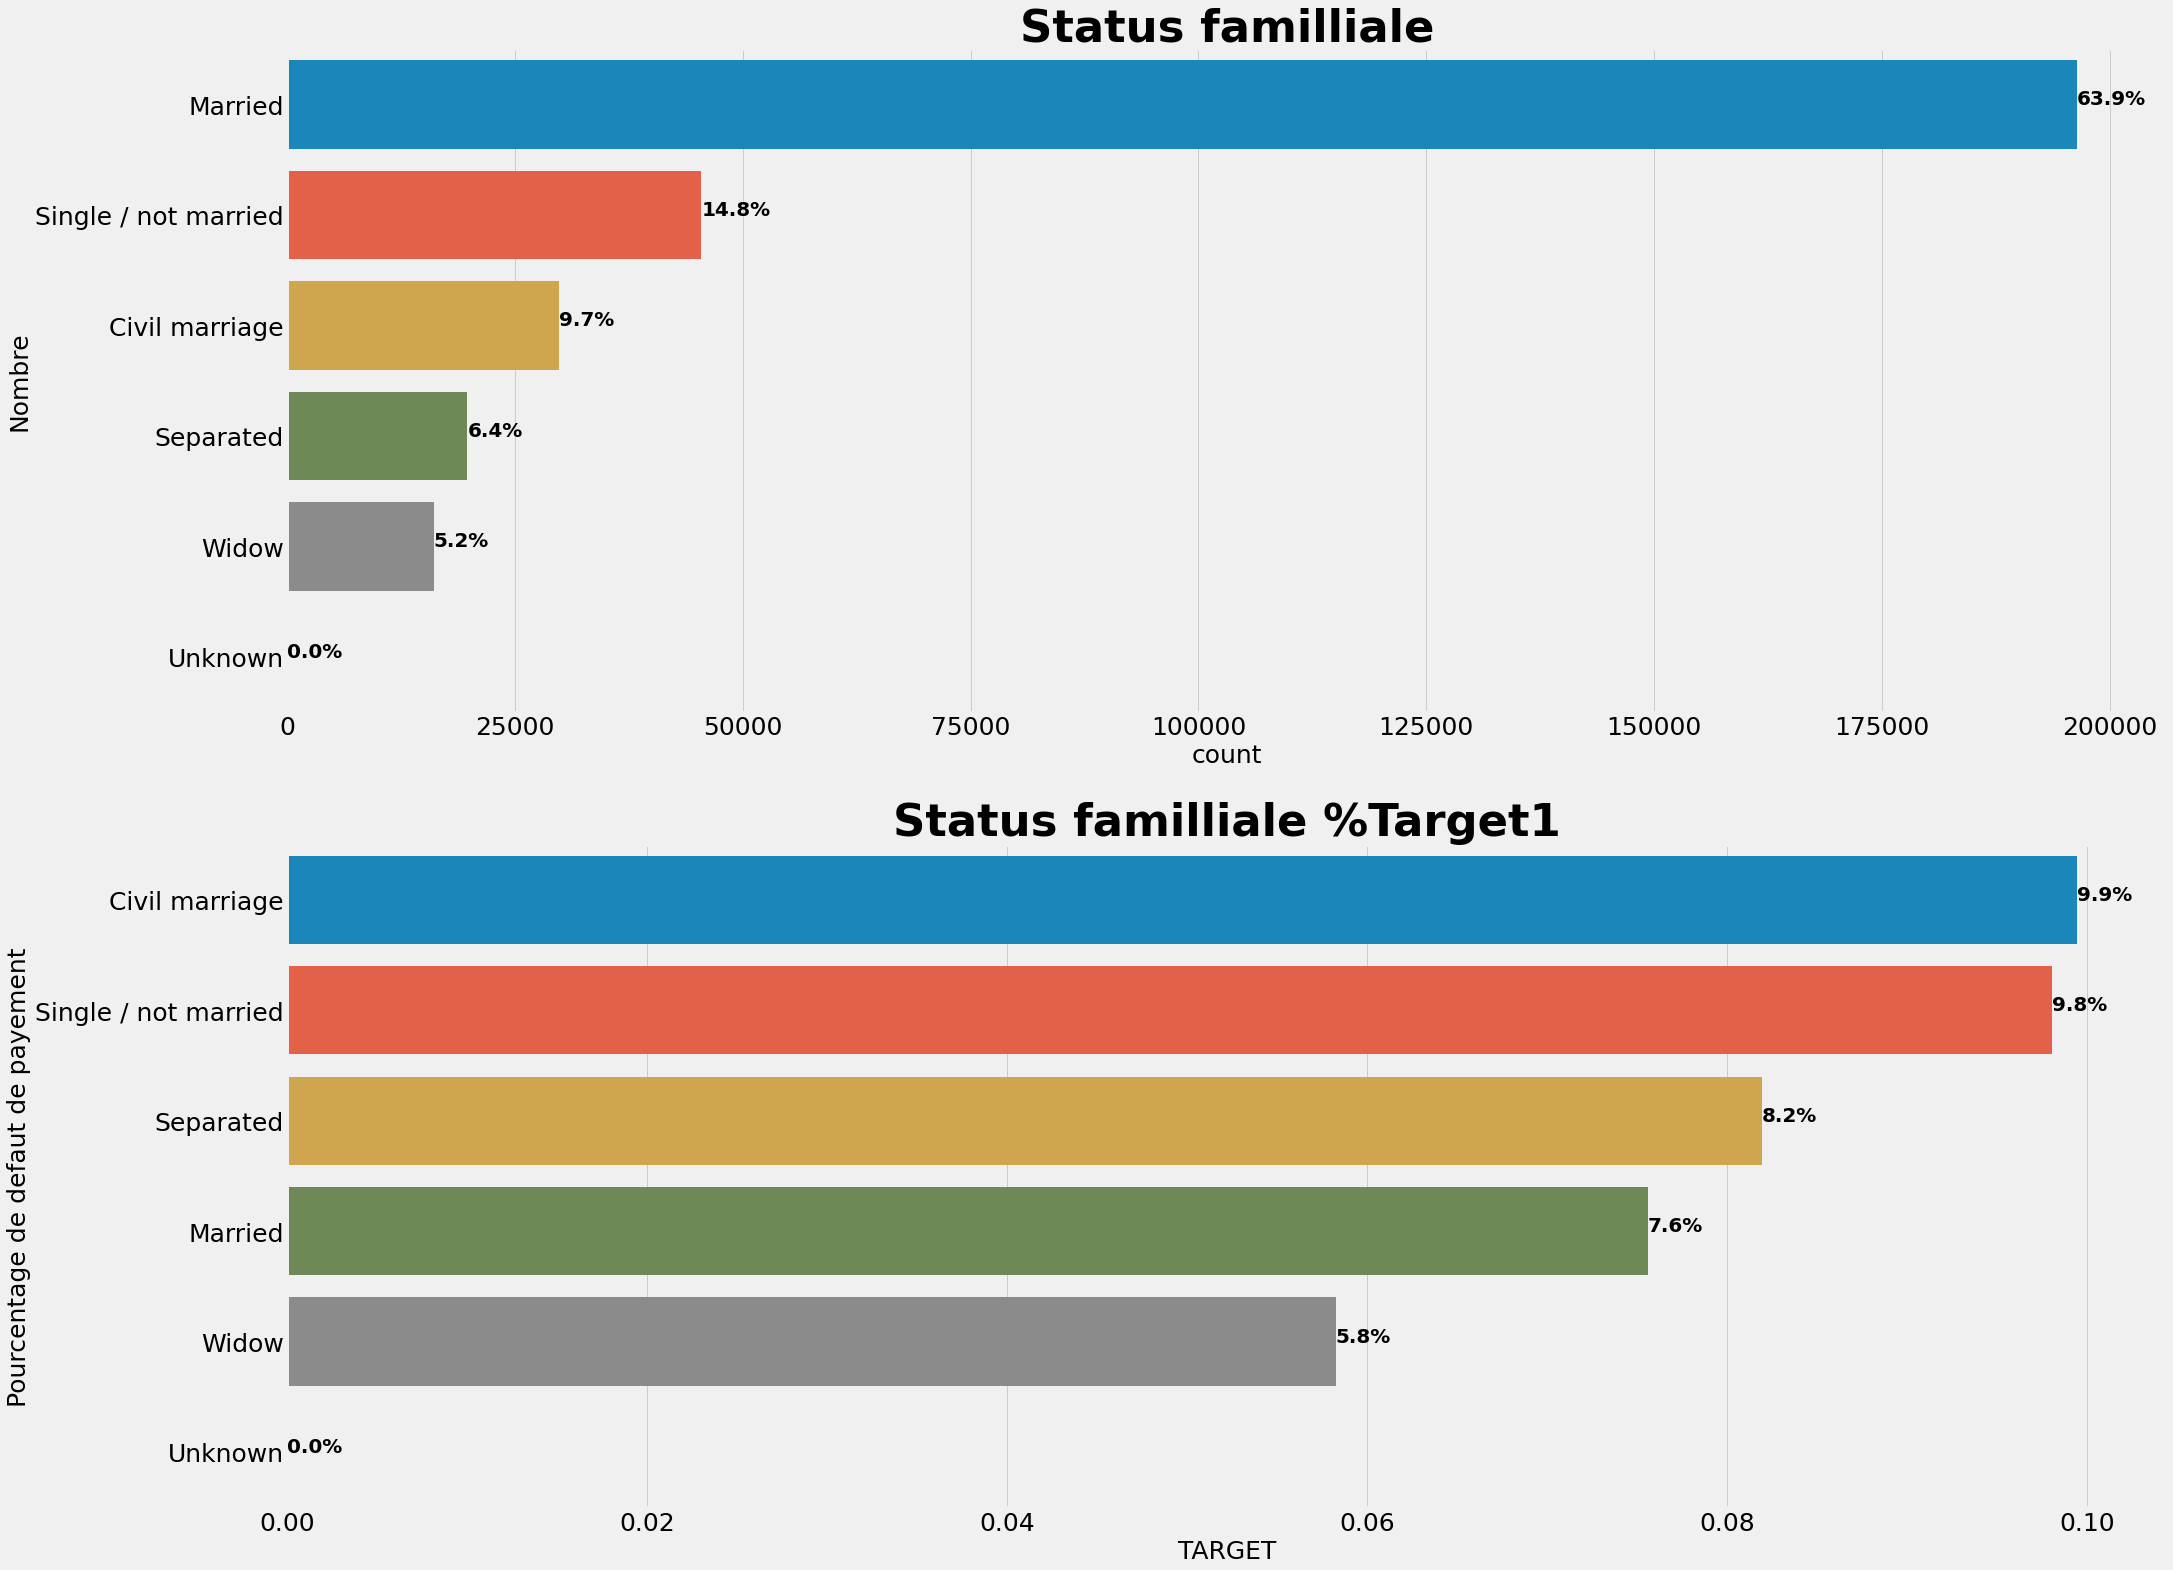

In [201]:
plot_stat2(application_train, 'NAME_FAMILY_STATUS',"Status familliale")

#### >>> PROPRIÉTÉ IMMOBILIÈRE (FLAG_OWN_REALTY)

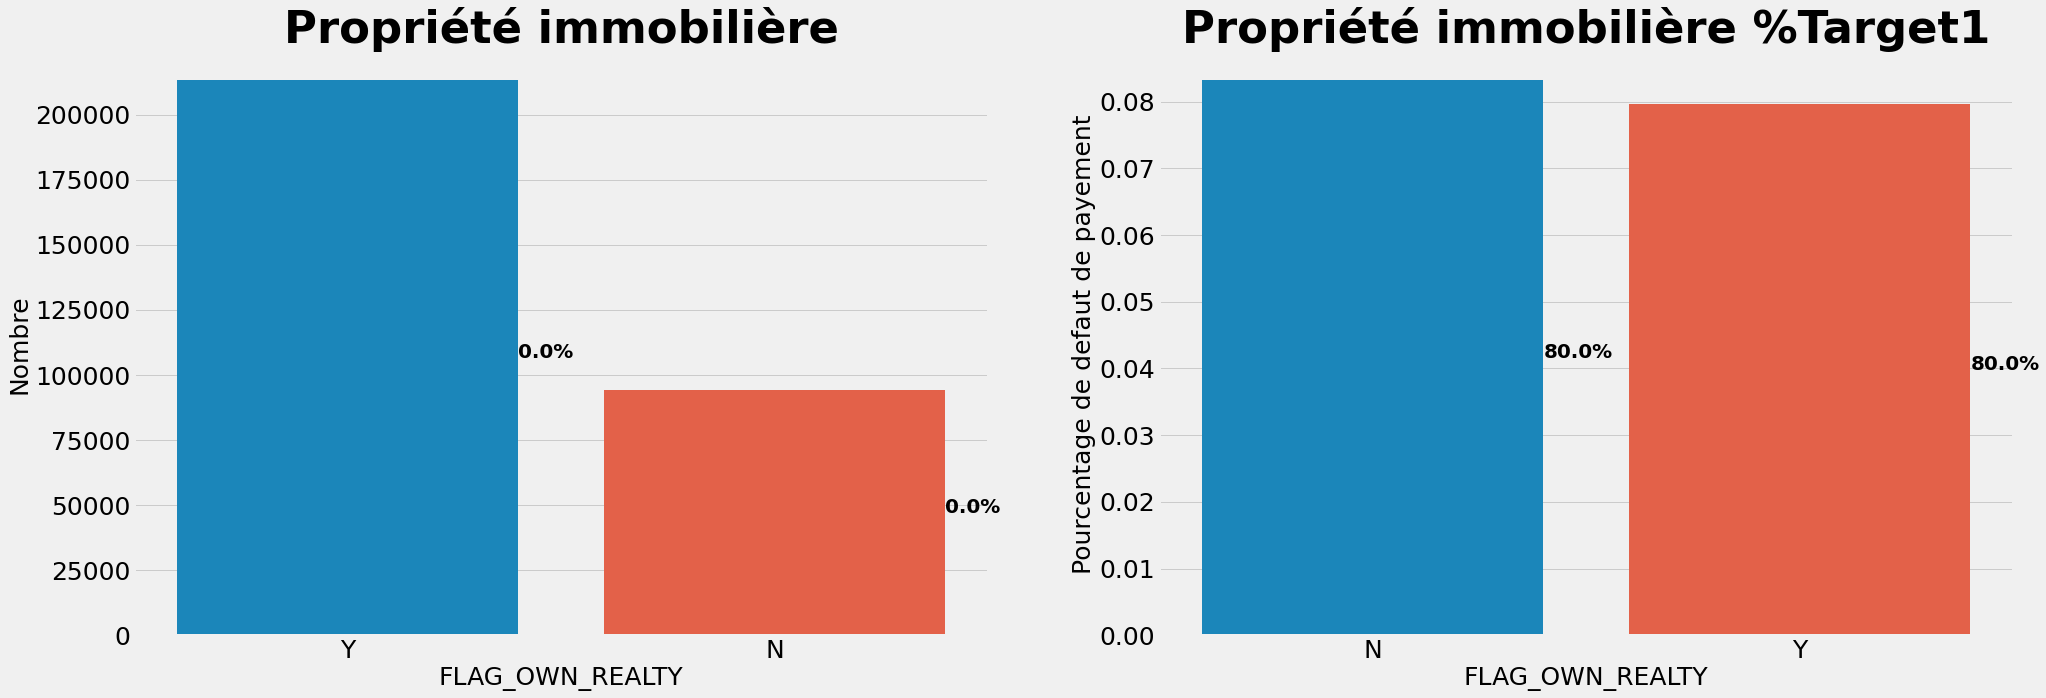

In [163]:
plot_stat(application_train, 'FLAG_OWN_REALTY',"Propriété immobilière")

#### >>> NAME_INCOME_TYPE

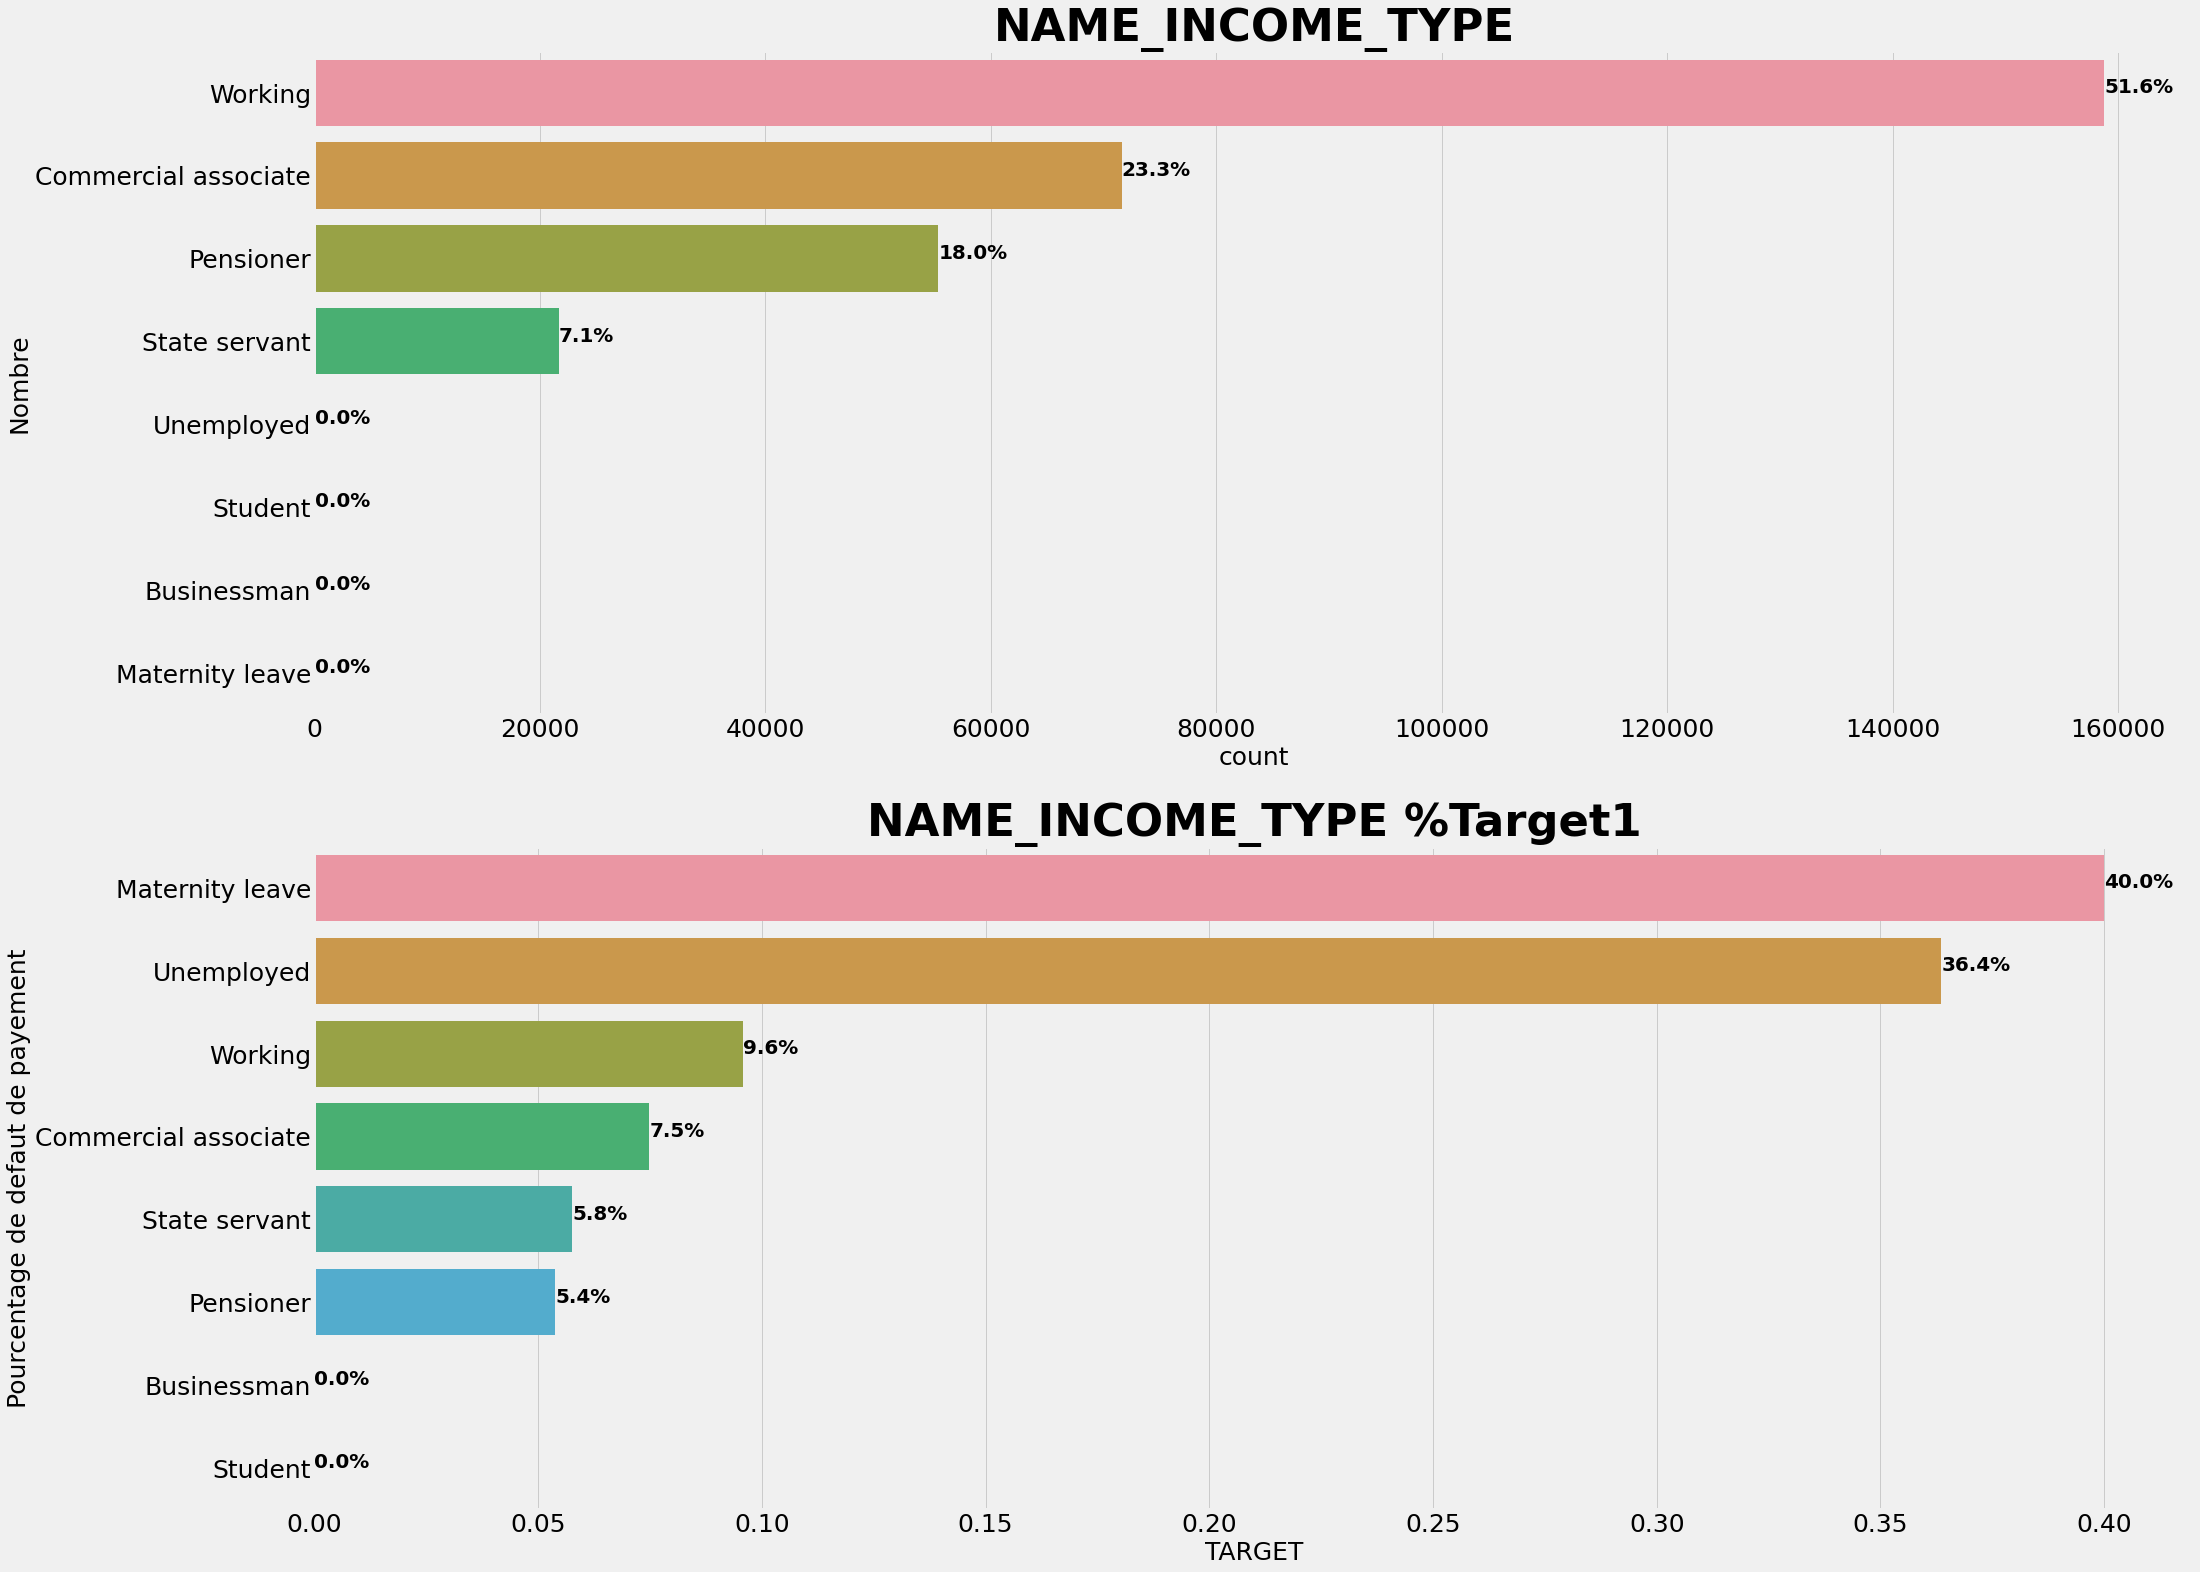

In [202]:
plot_stat2(application_train, 'NAME_INCOME_TYPE',"NAME_INCOME_TYPE")

#### >>> NAME_EDUCATION_TYPE

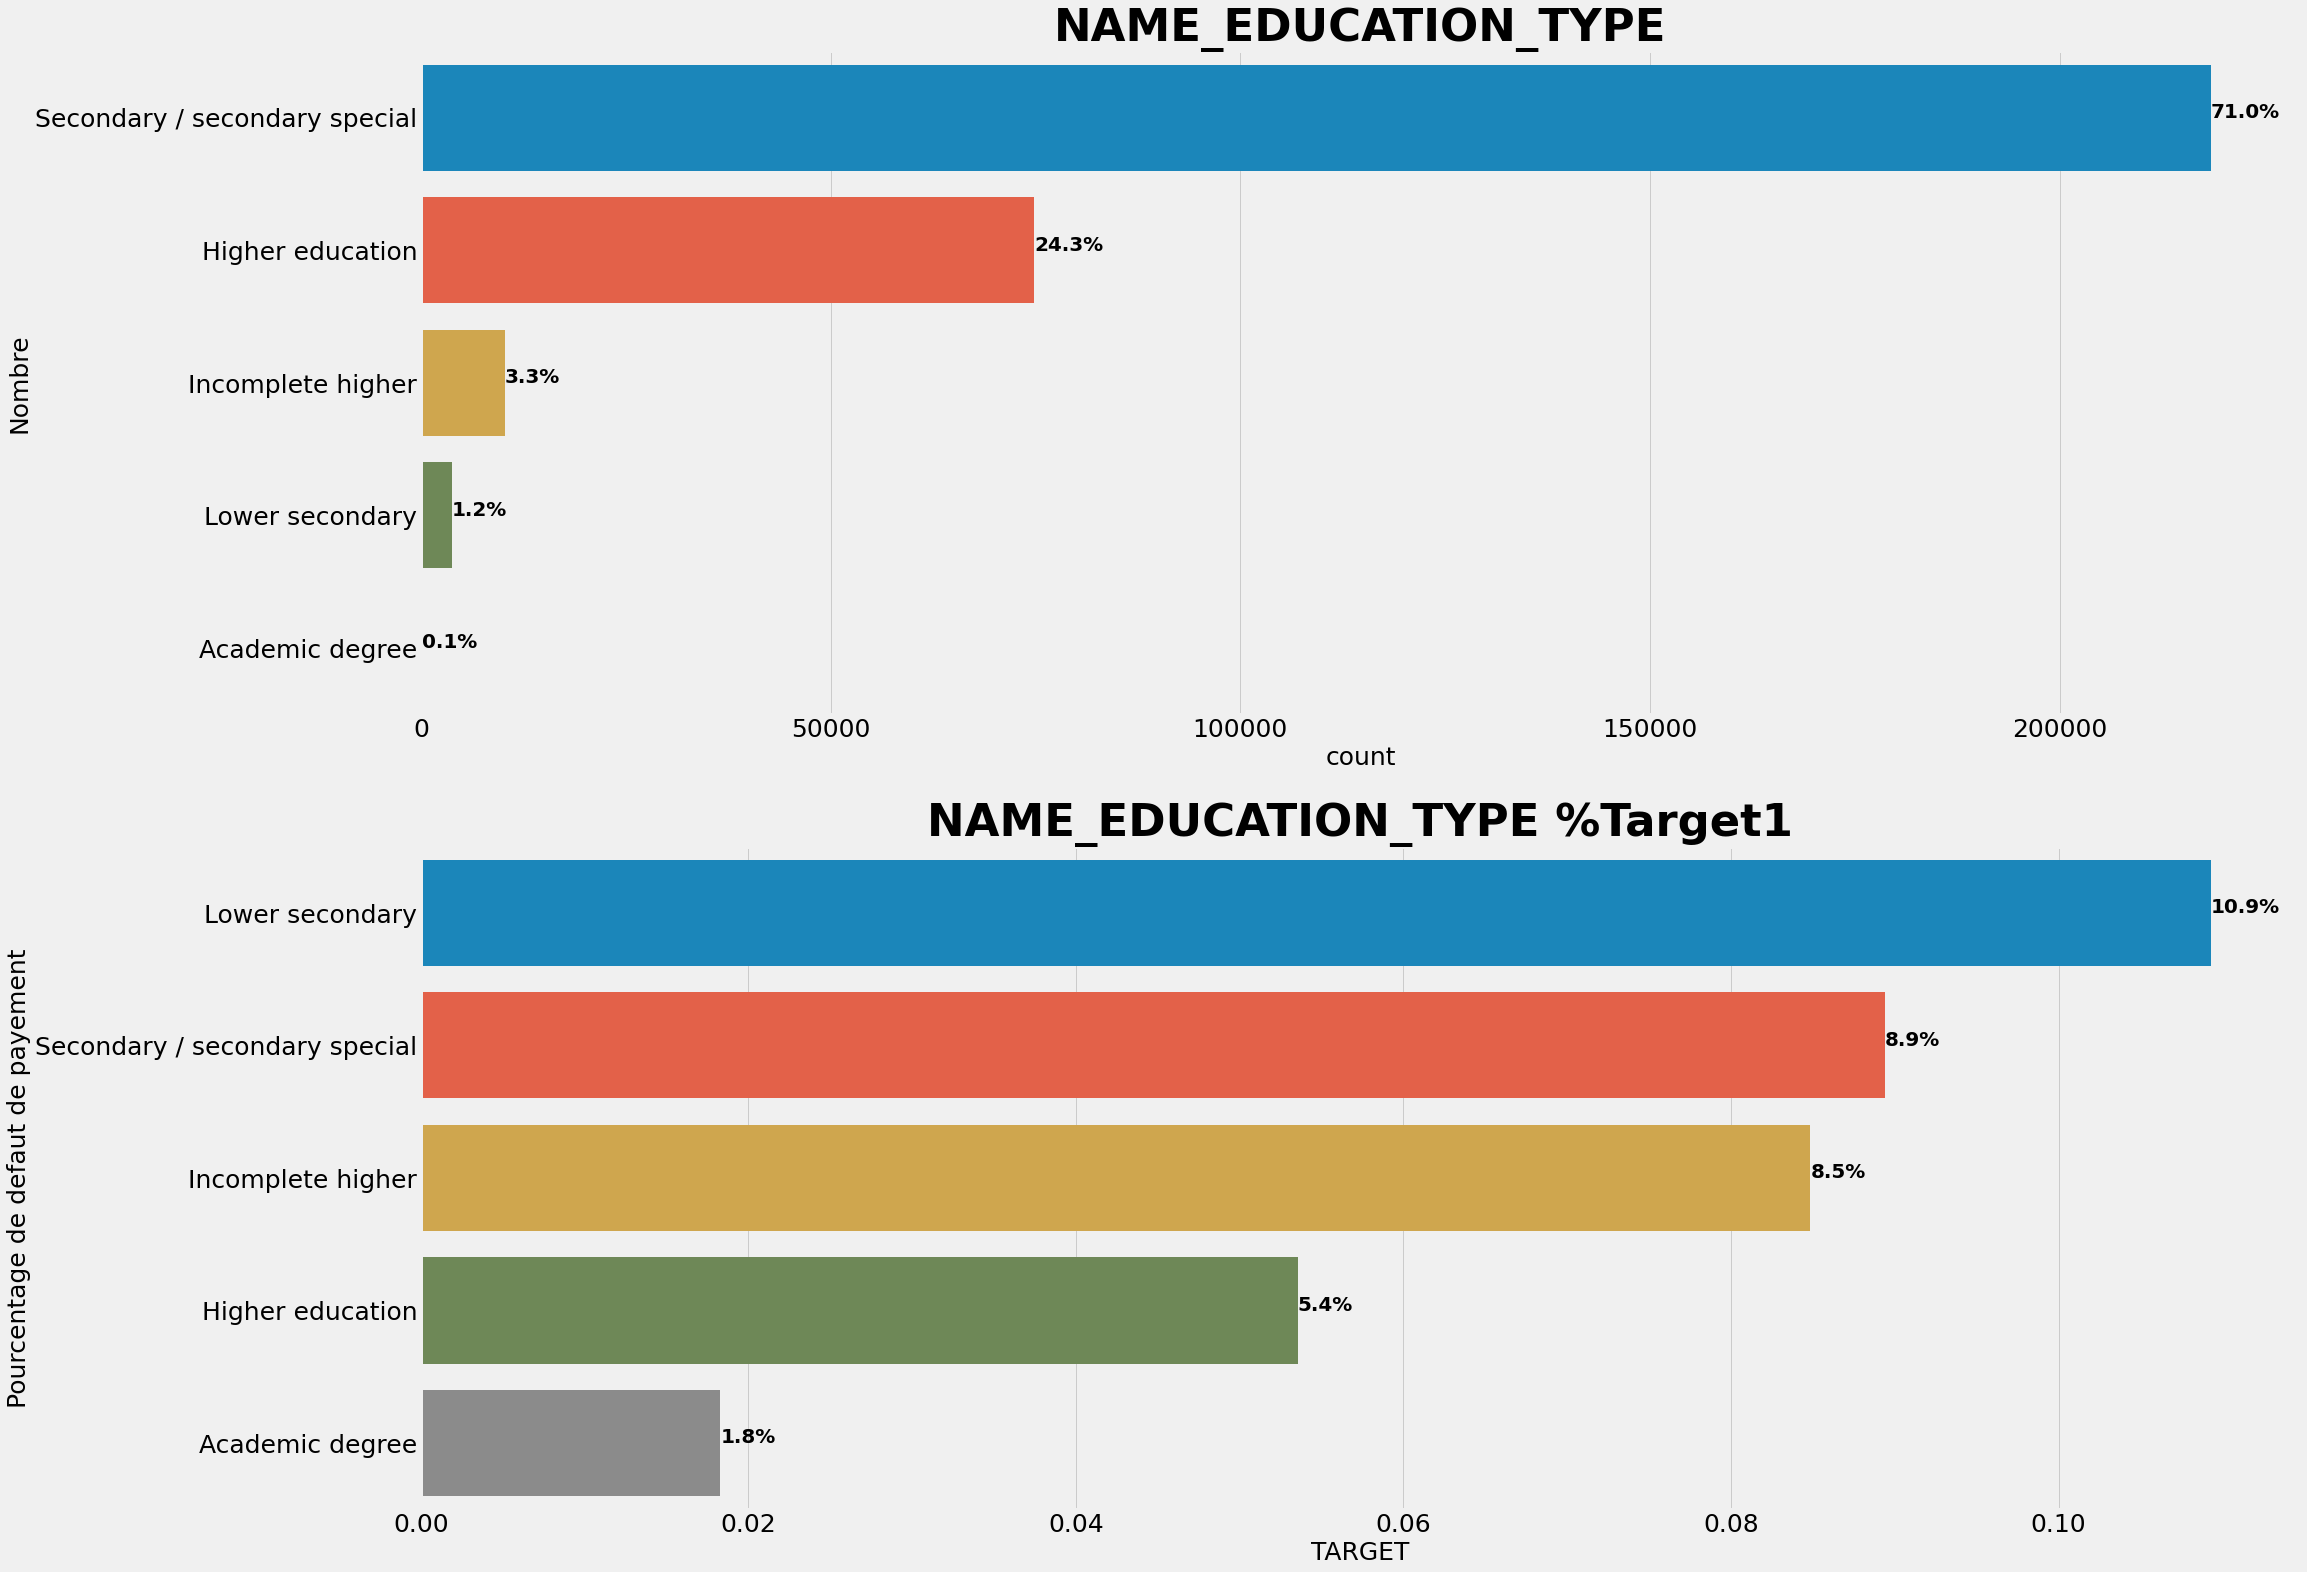

In [203]:
plot_stat2(application_train, 'NAME_EDUCATION_TYPE',"NAME_EDUCATION_TYPE")

#### >>> NAME_FAMILY_STATUS

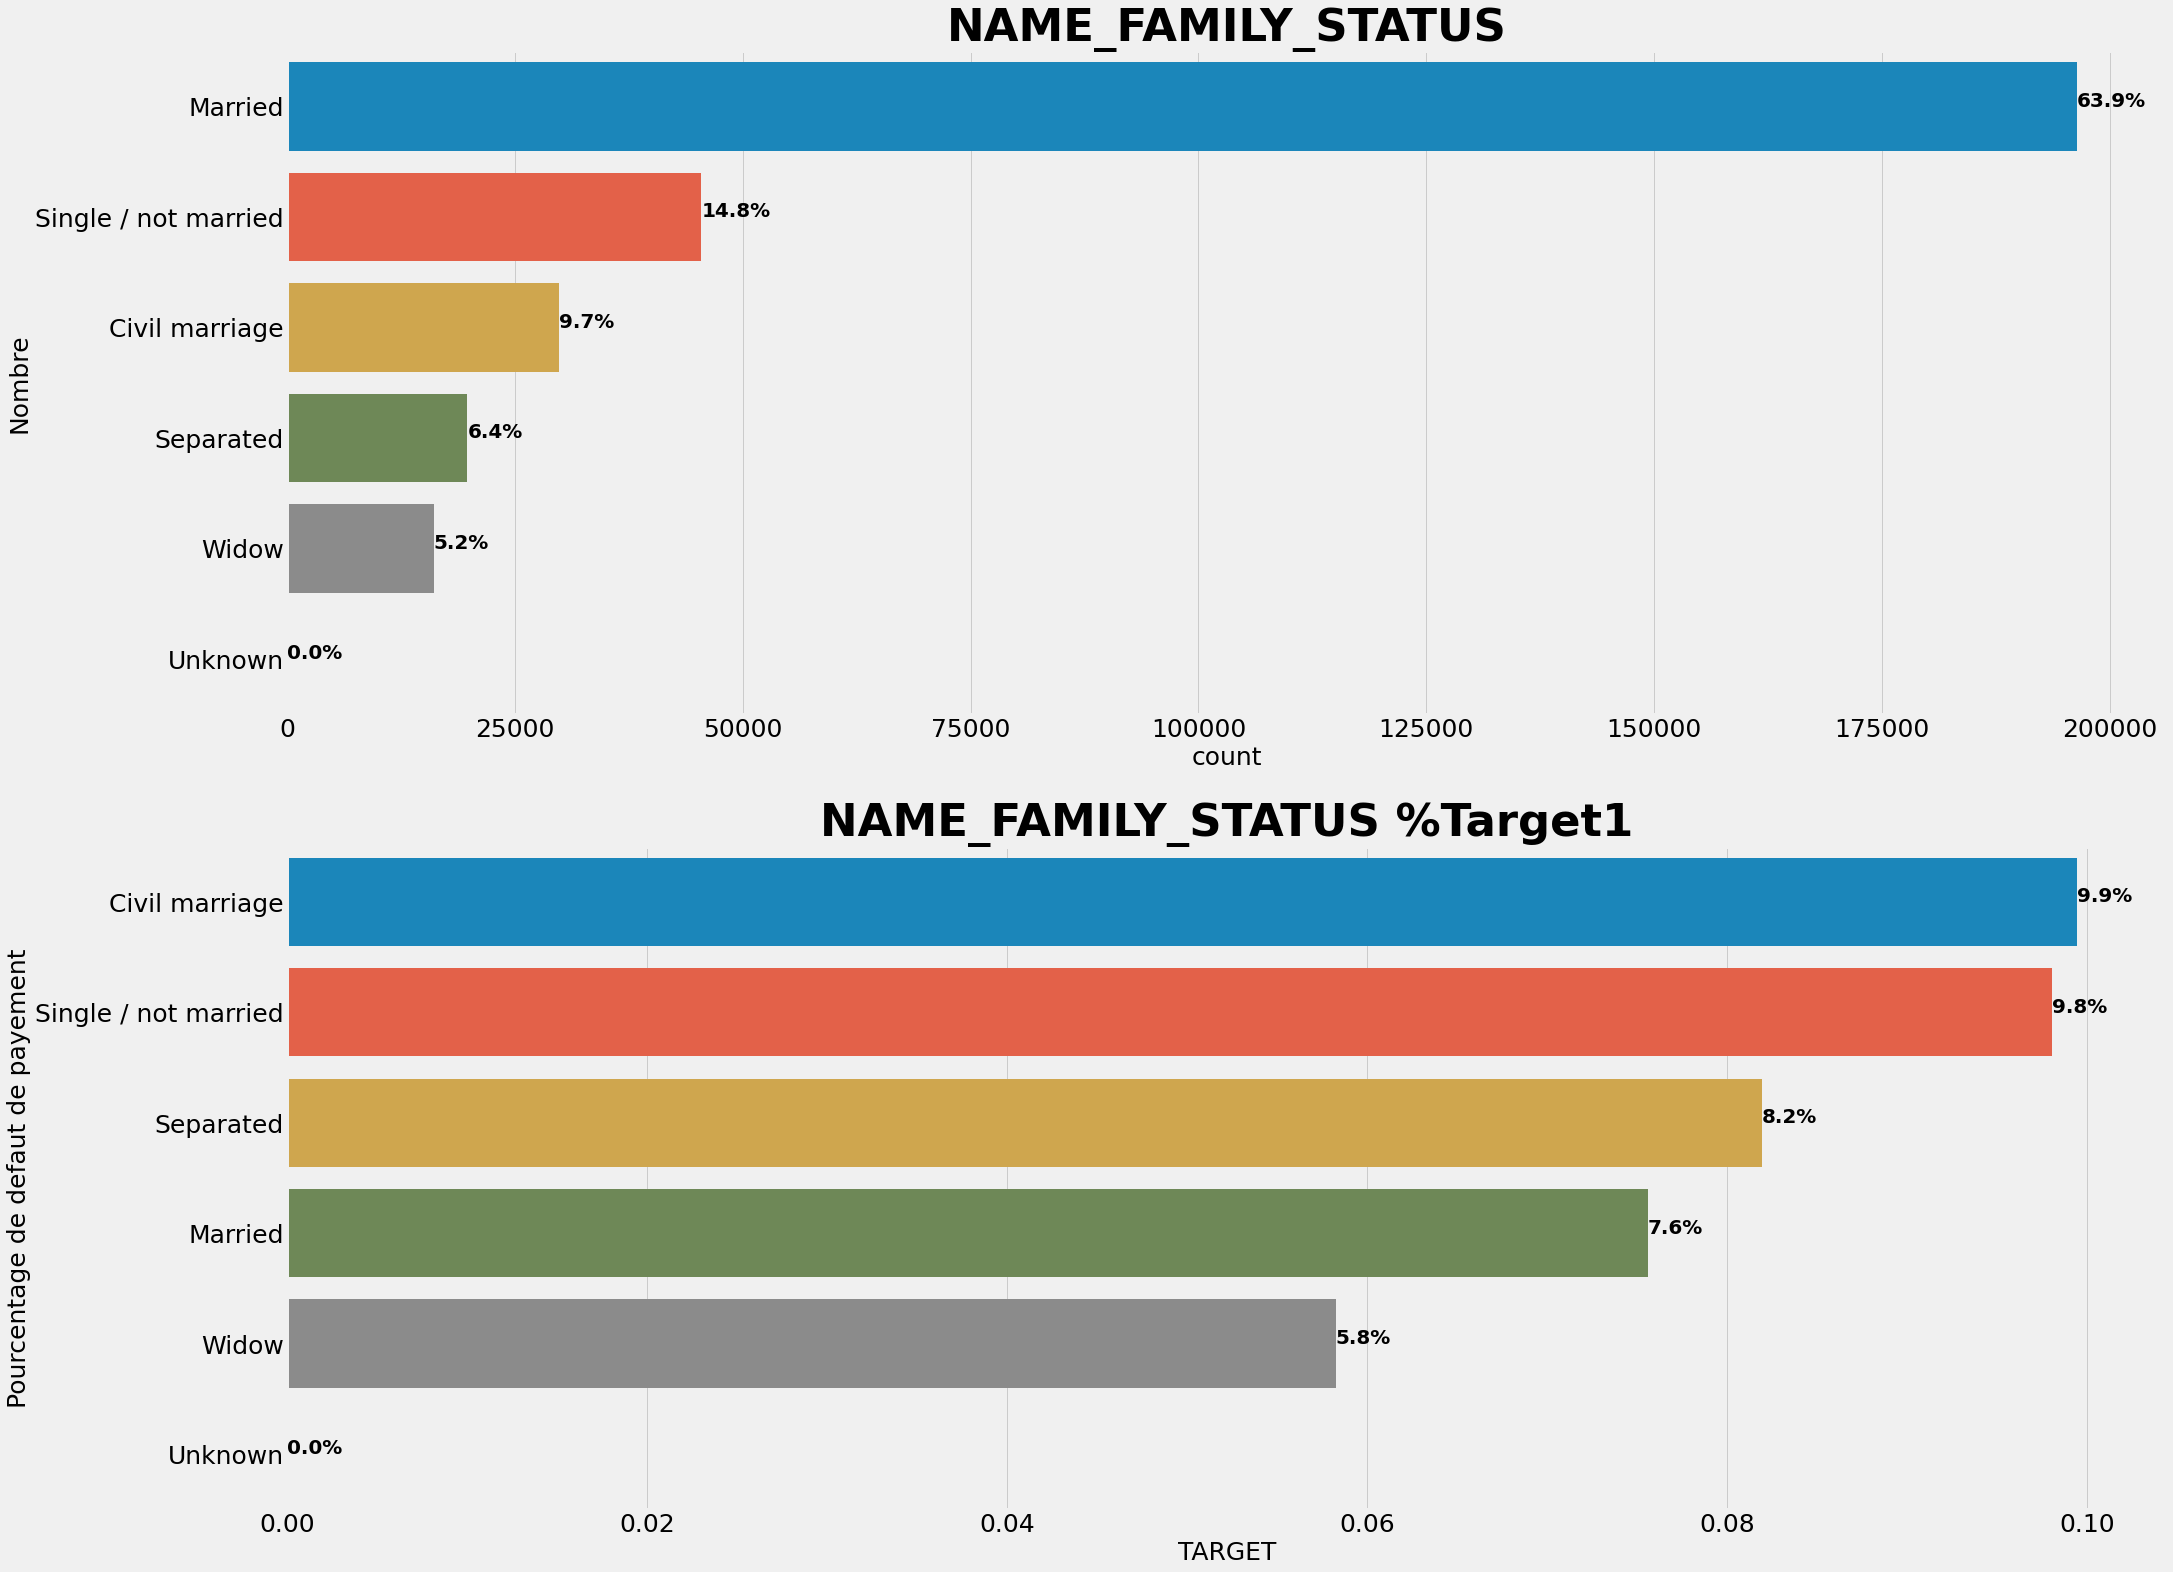

In [204]:
plot_stat2(application_train, 'NAME_FAMILY_STATUS',"NAME_FAMILY_STATUS")

#### >>> NAME_HOUSING_TYPE

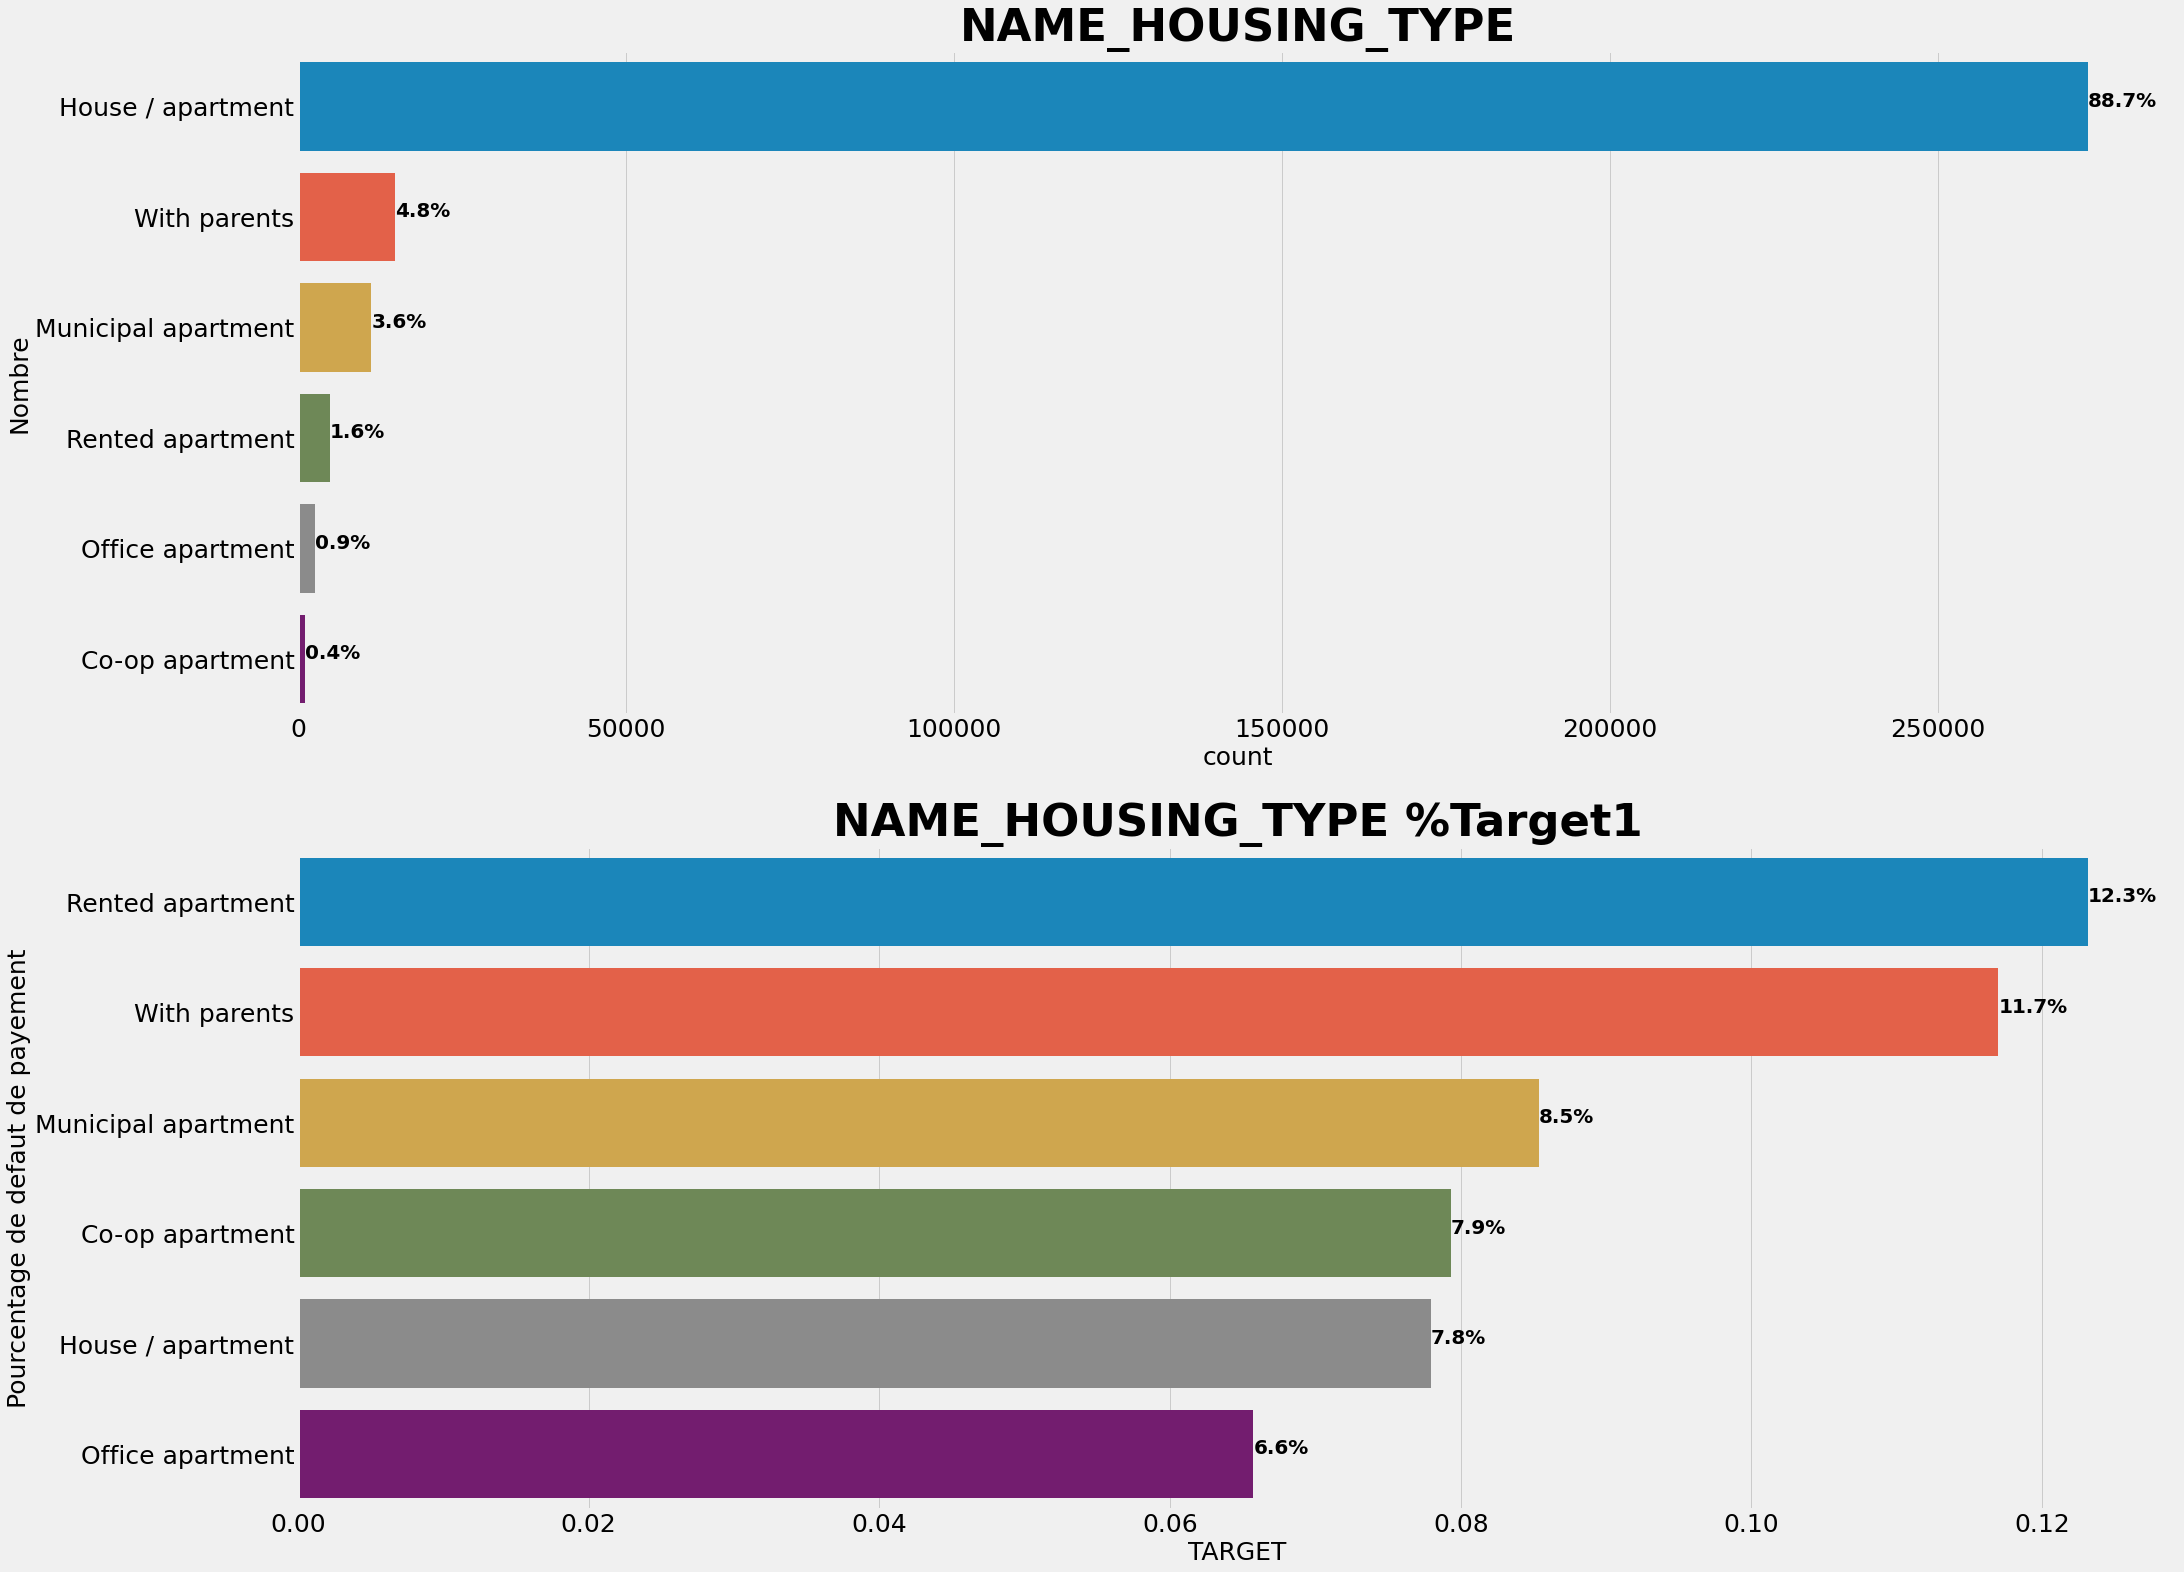

In [205]:
plot_stat2(application_train, 'NAME_HOUSING_TYPE',"NAME_HOUSING_TYPE")

#### >>> OCCUPATION_TYPE

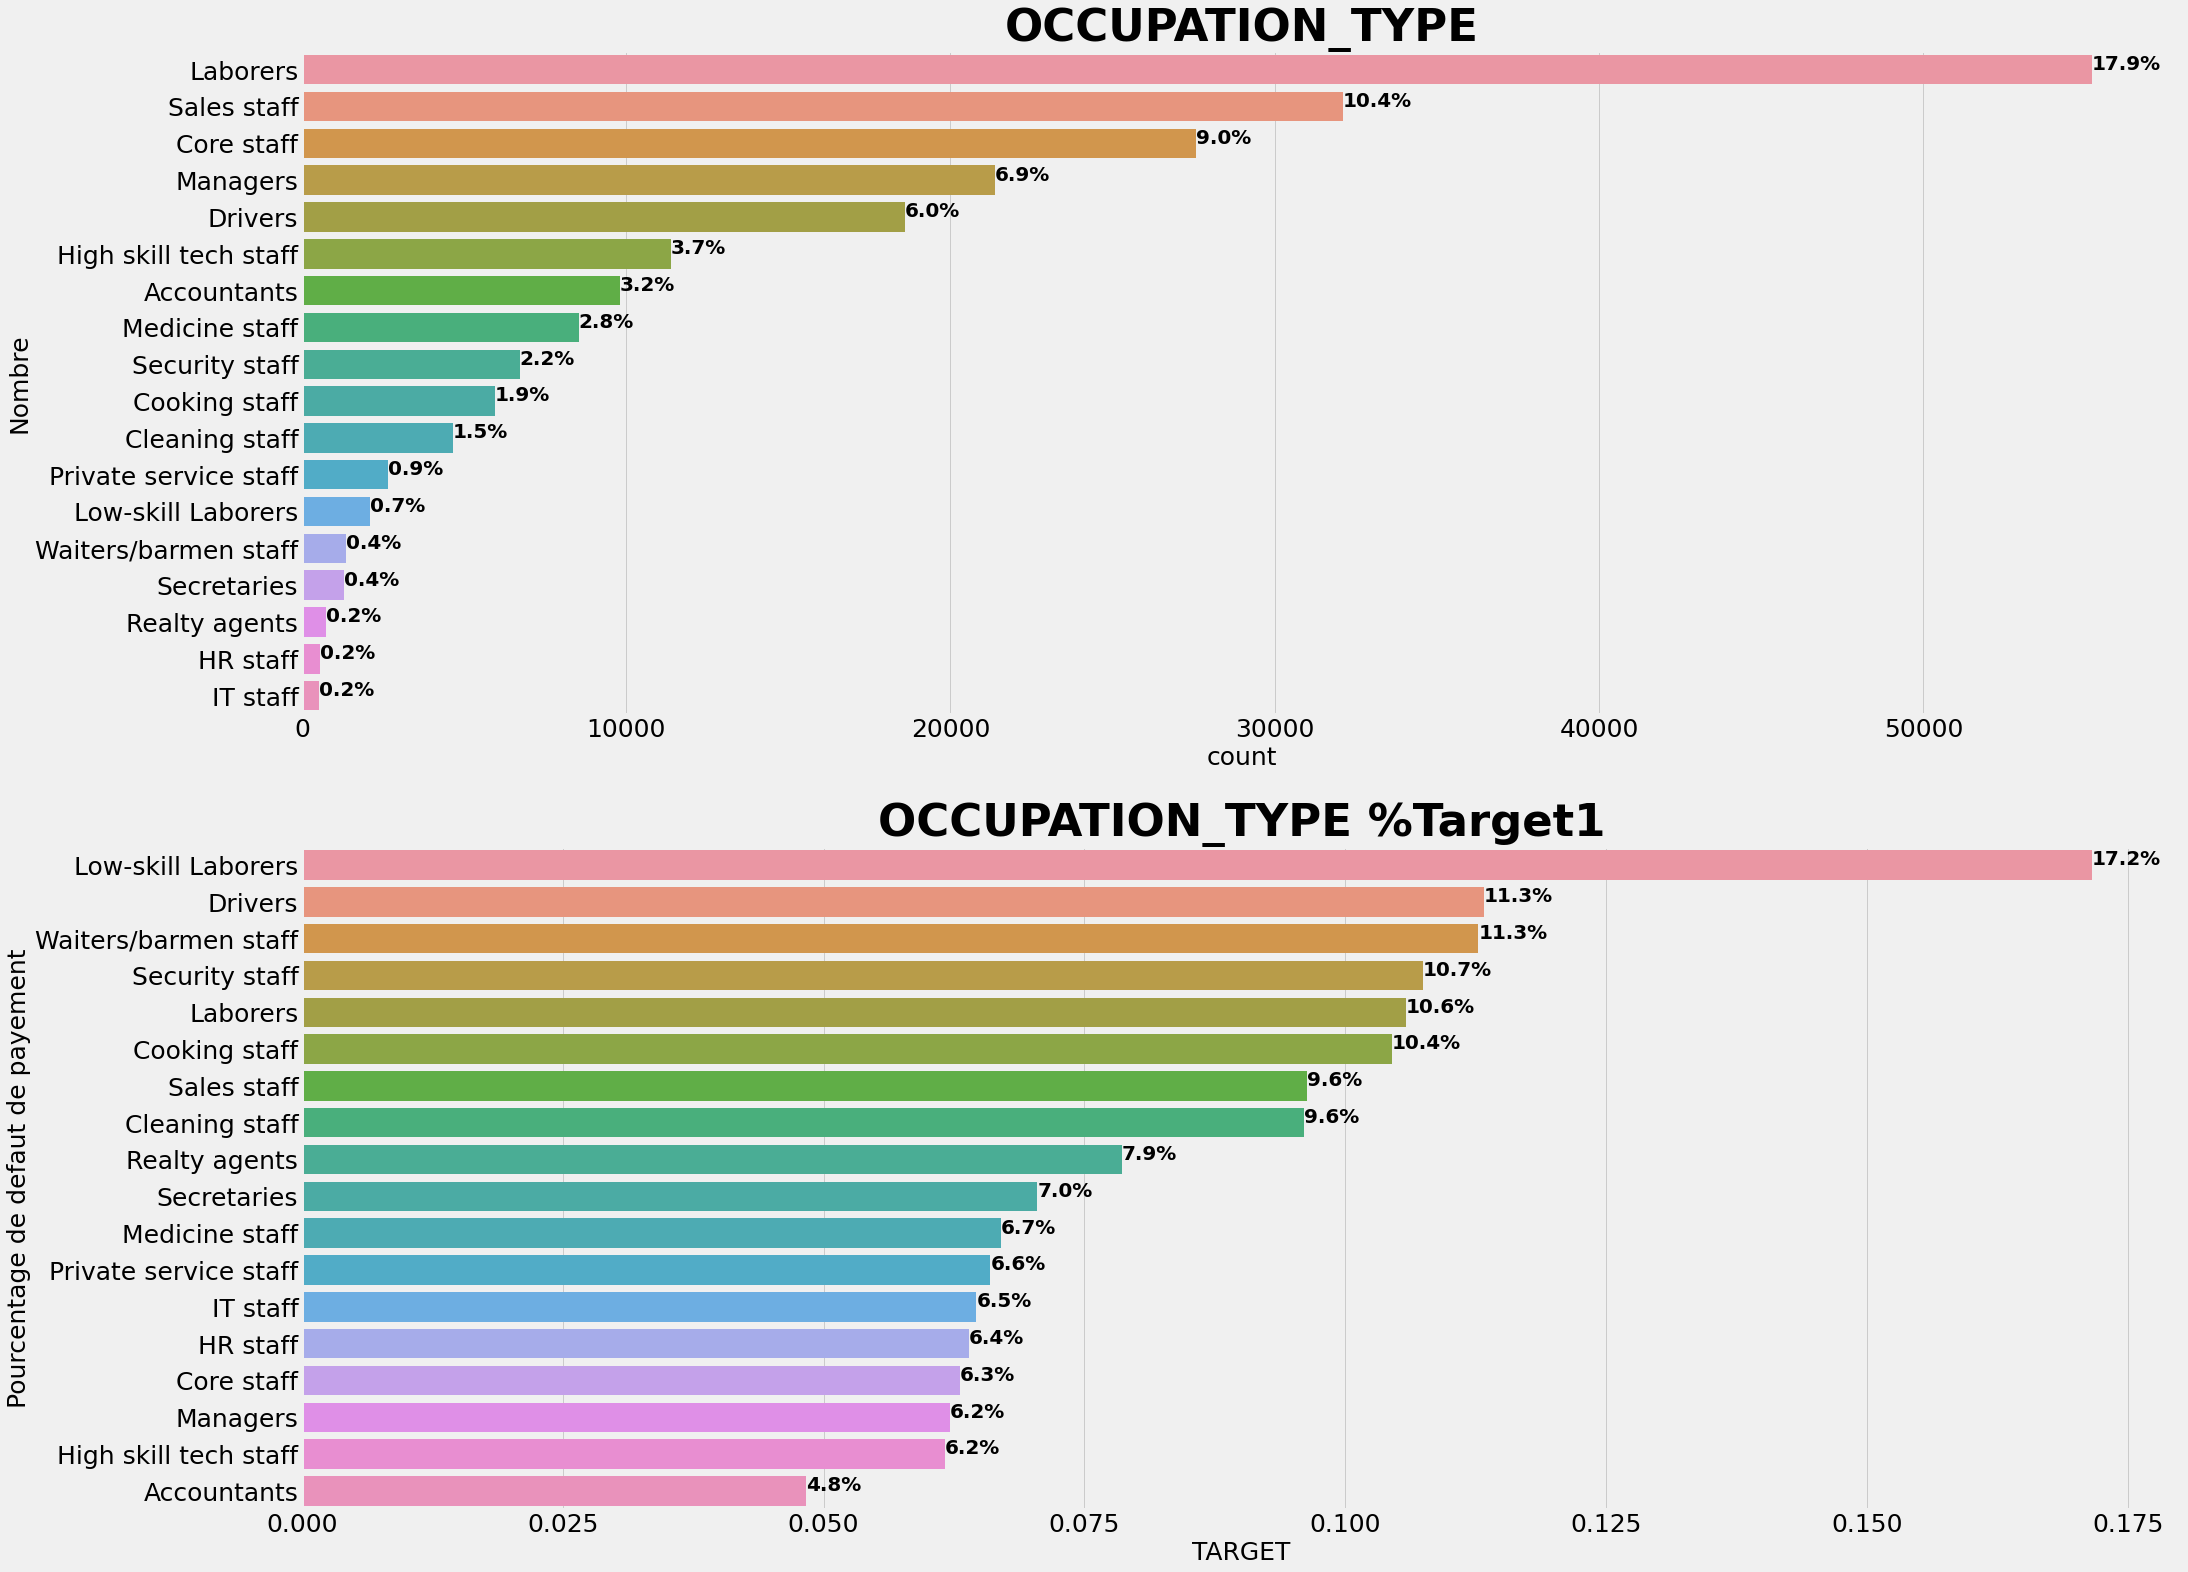

In [206]:
plot_stat2(application_train, 'OCCUPATION_TYPE',"OCCUPATION_TYPE")

#### >>> WEEKDAY_APPR_PROCESS_START

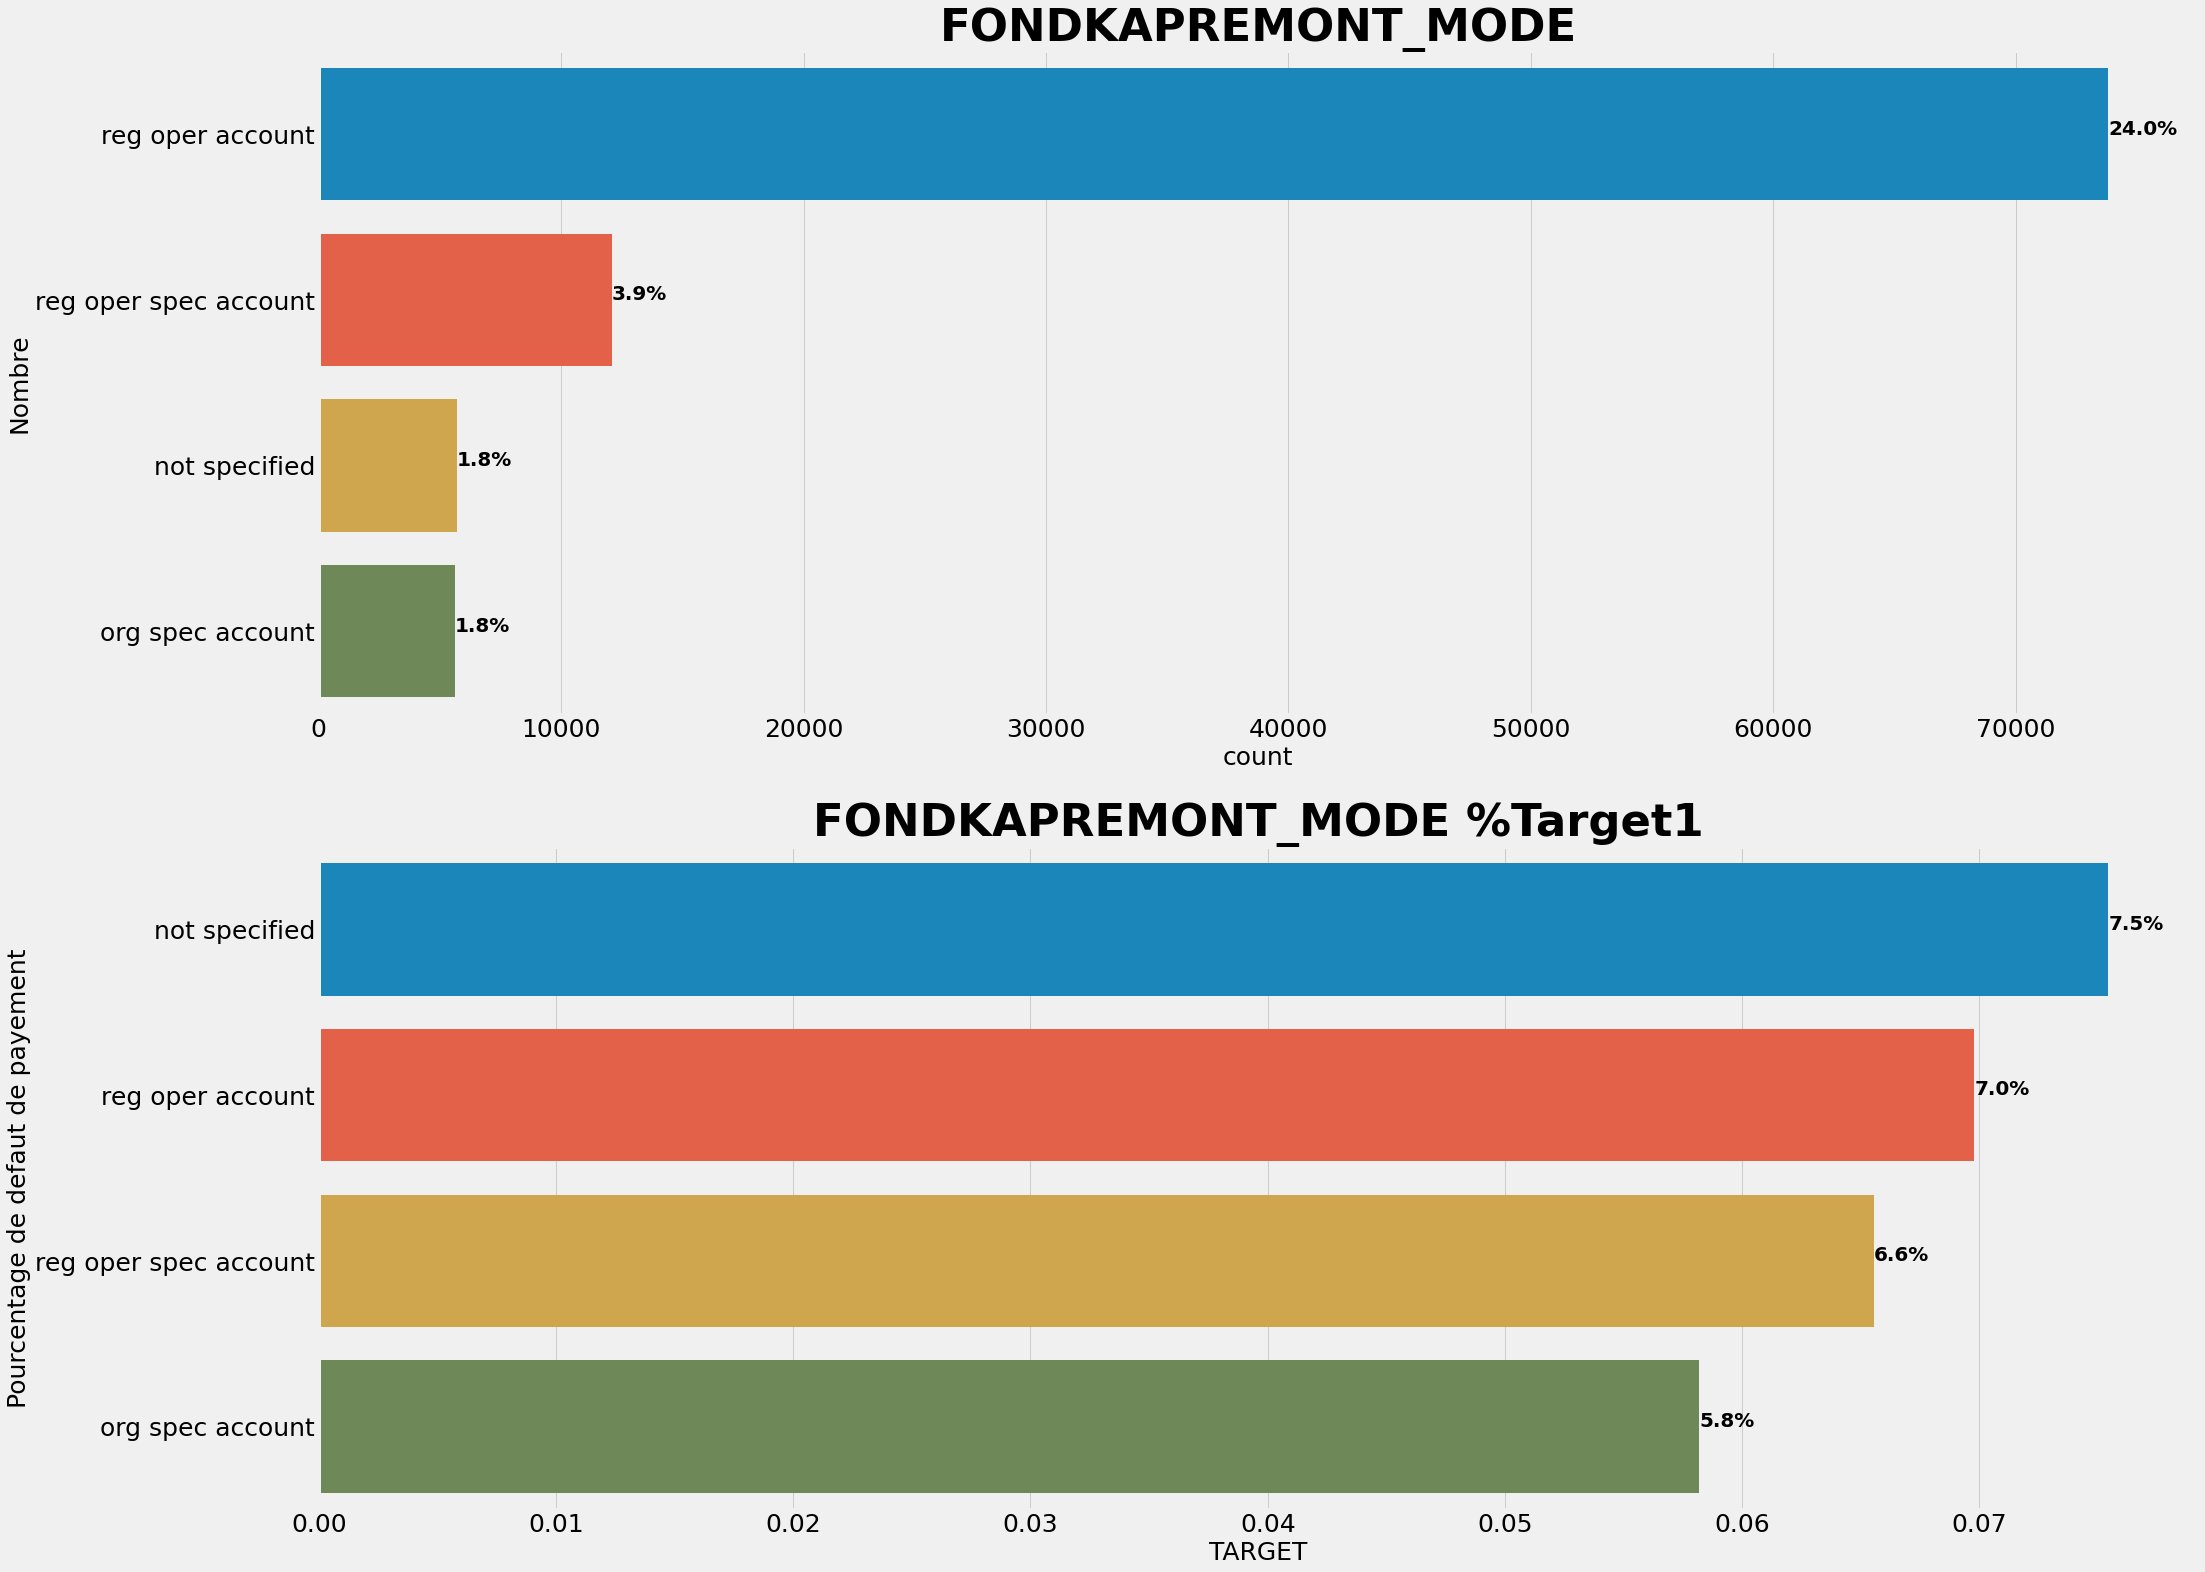

In [207]:
plot_stat2(application_train, 'FONDKAPREMONT_MODE',"FONDKAPREMONT_MODE")

#### >>> HOUSETYPE_MODE

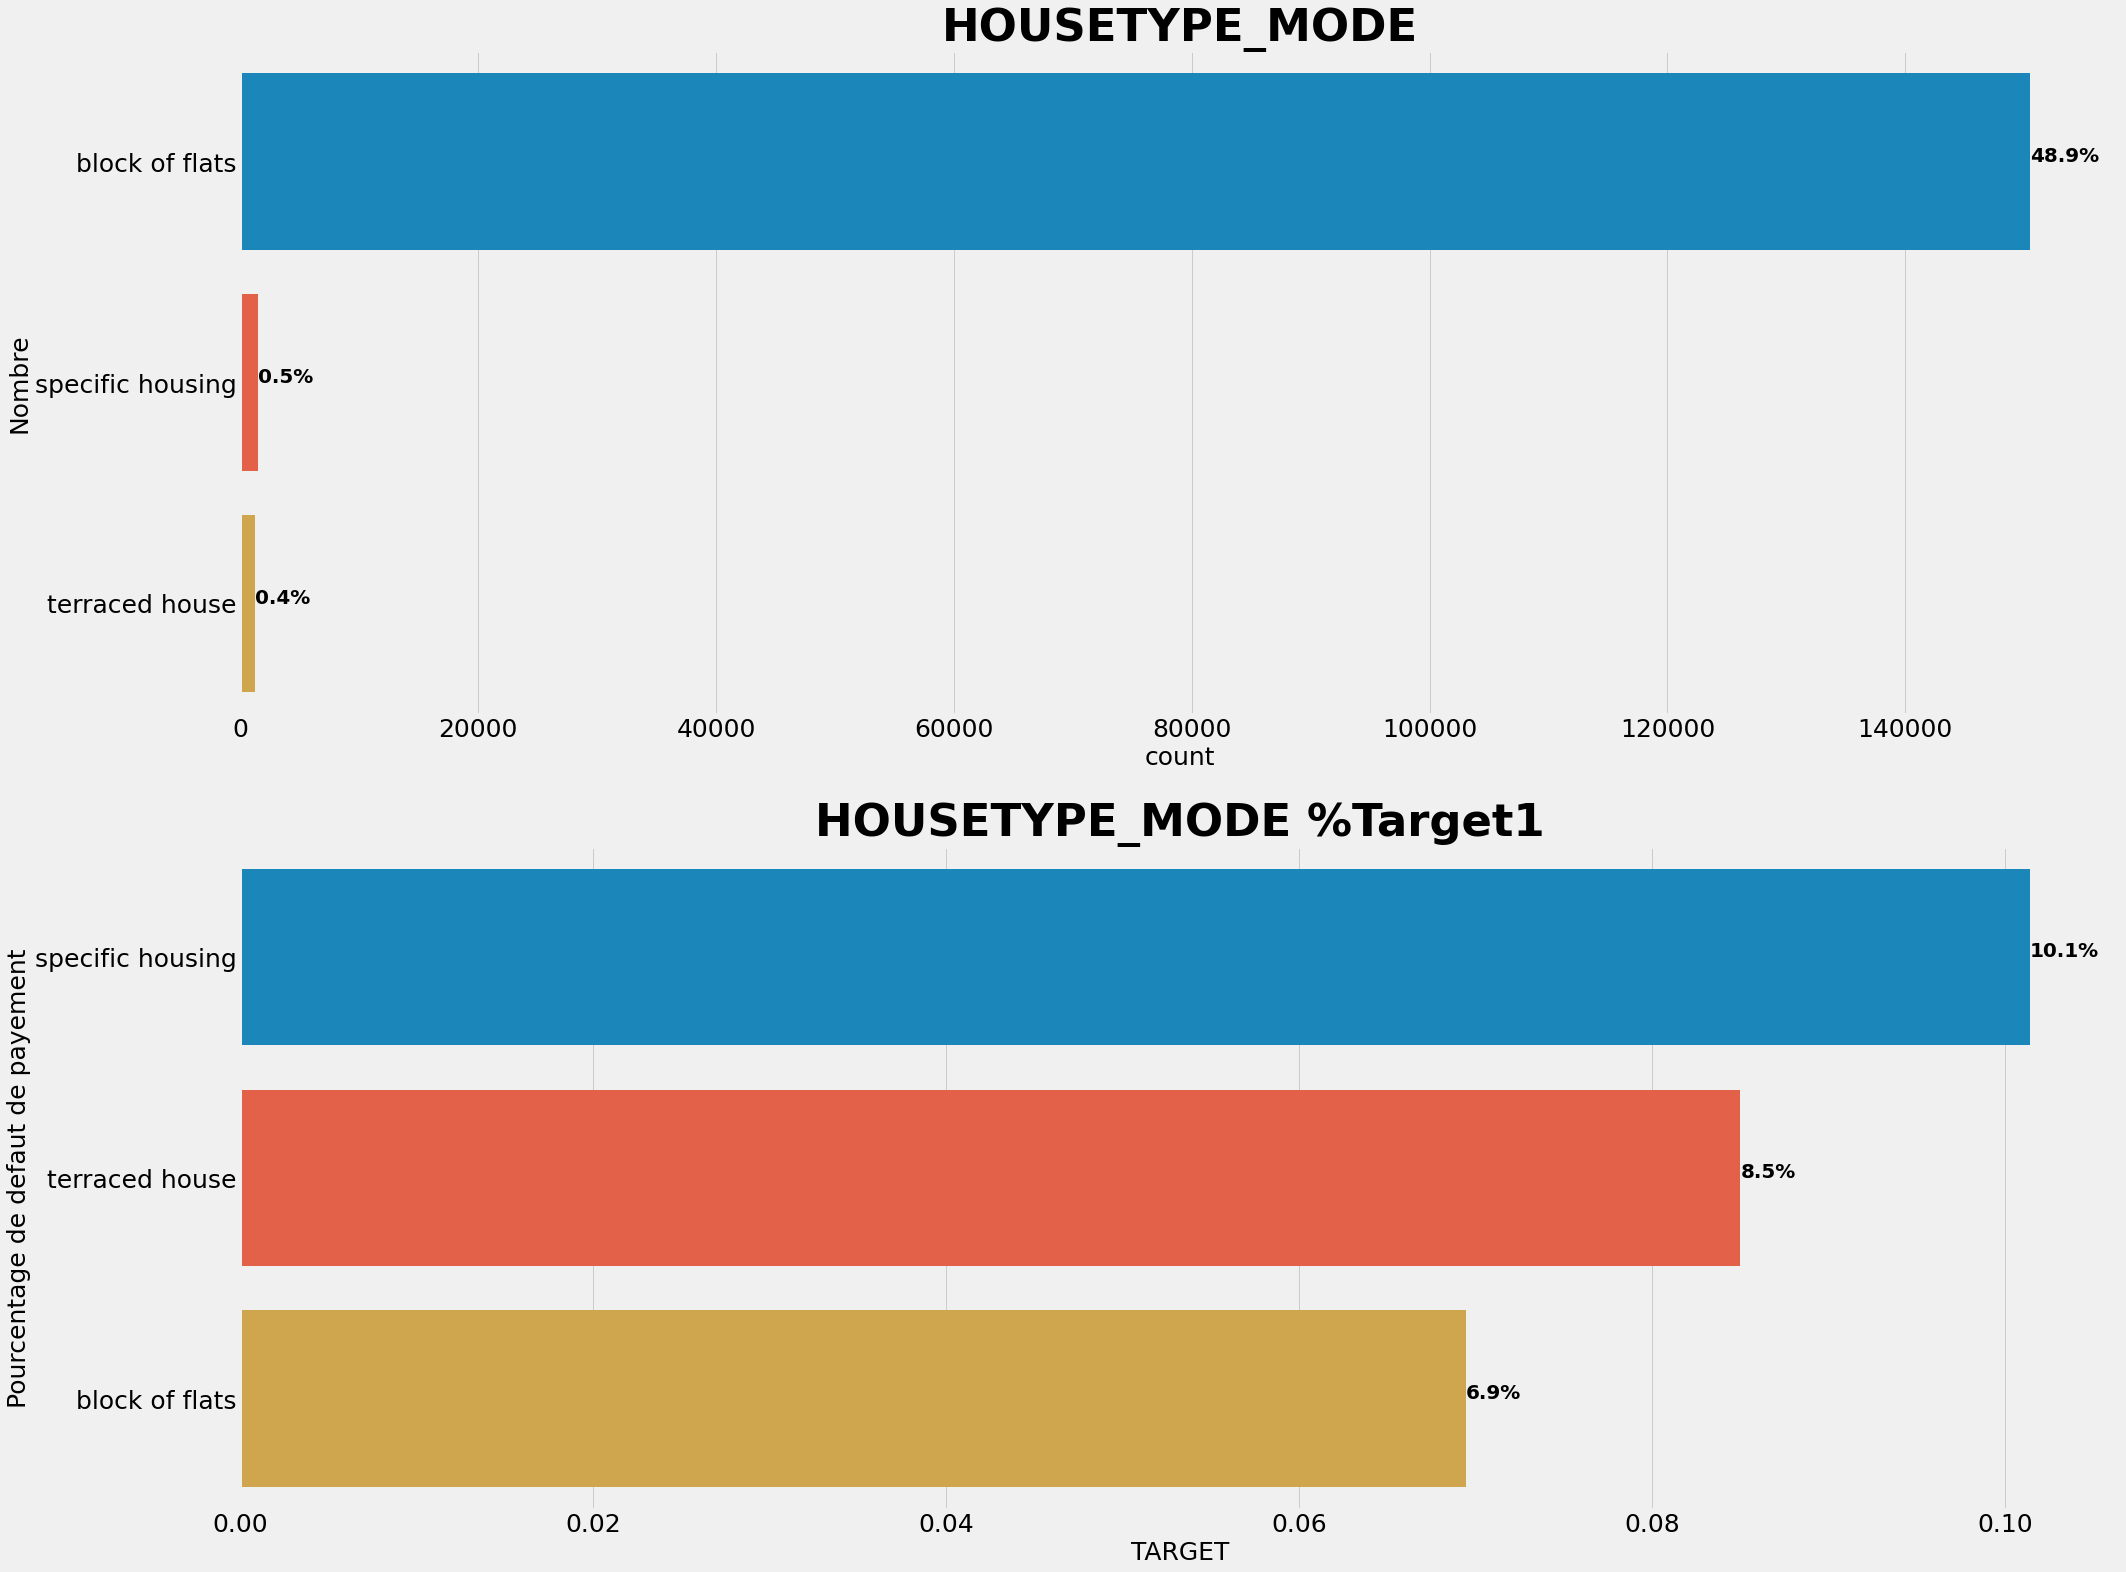

In [208]:
plot_stat2(application_train, 'HOUSETYPE_MODE',"HOUSETYPE_MODE")

#### >>> WALLSMATERIAL_MODE

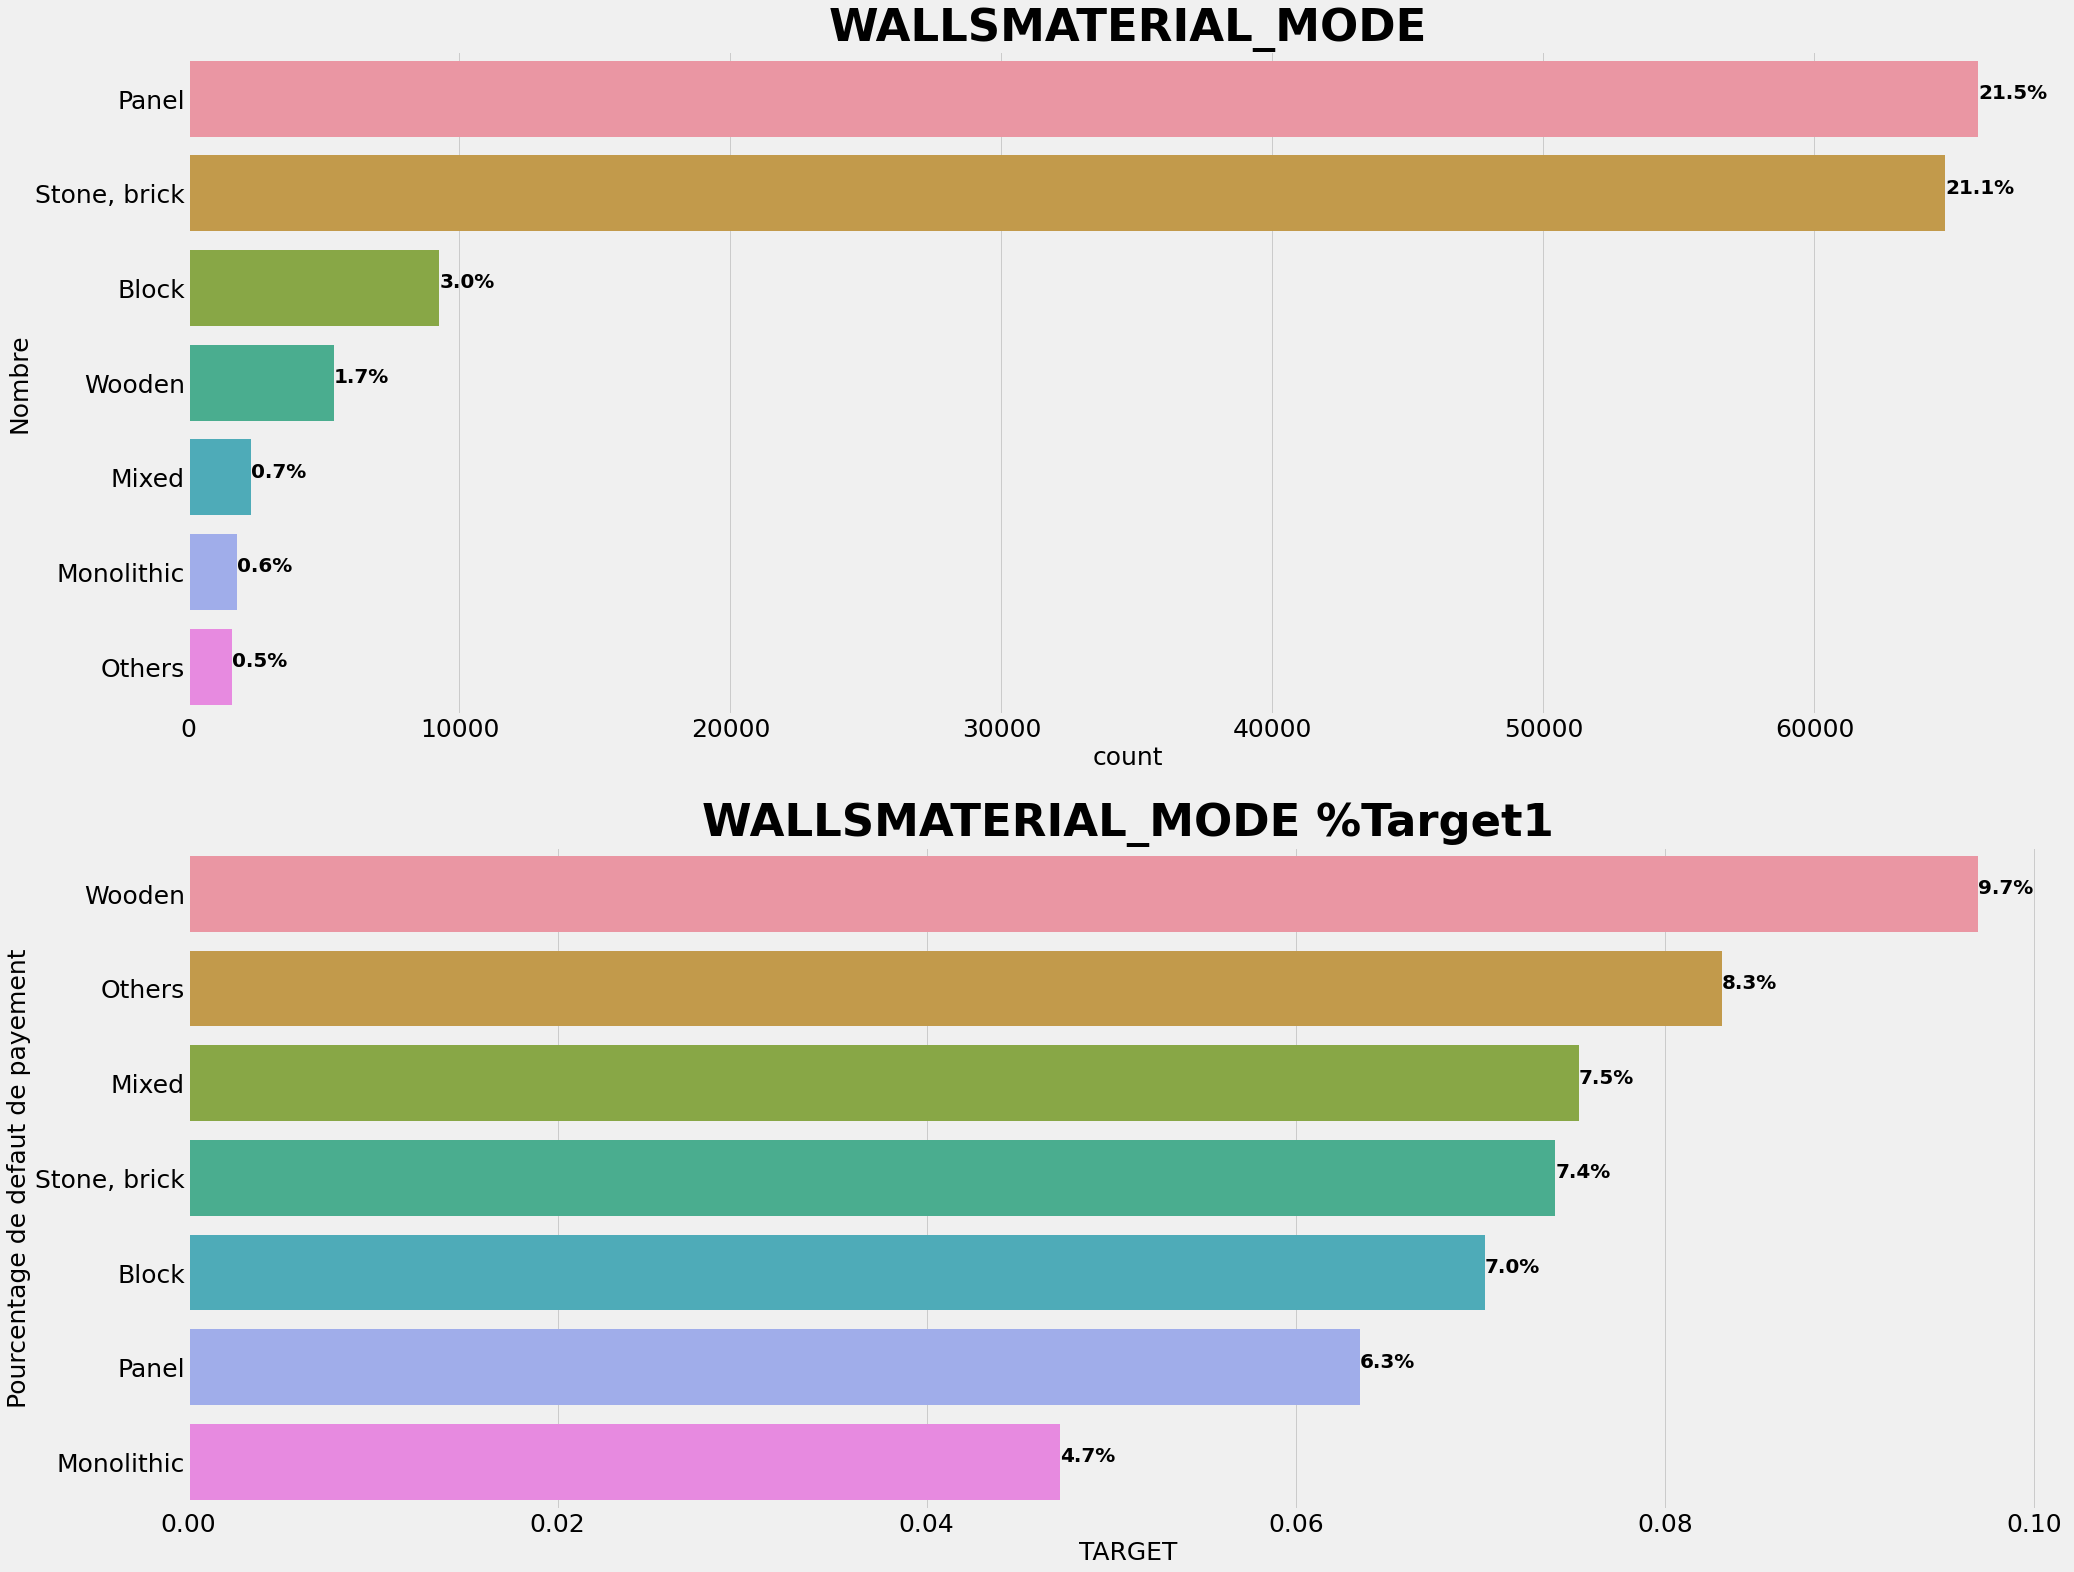

In [209]:
plot_stat2(application_train, 'WALLSMATERIAL_MODE',"WALLSMATERIAL_MODE")

#### >>> EMERGENCYSTATE_MODE

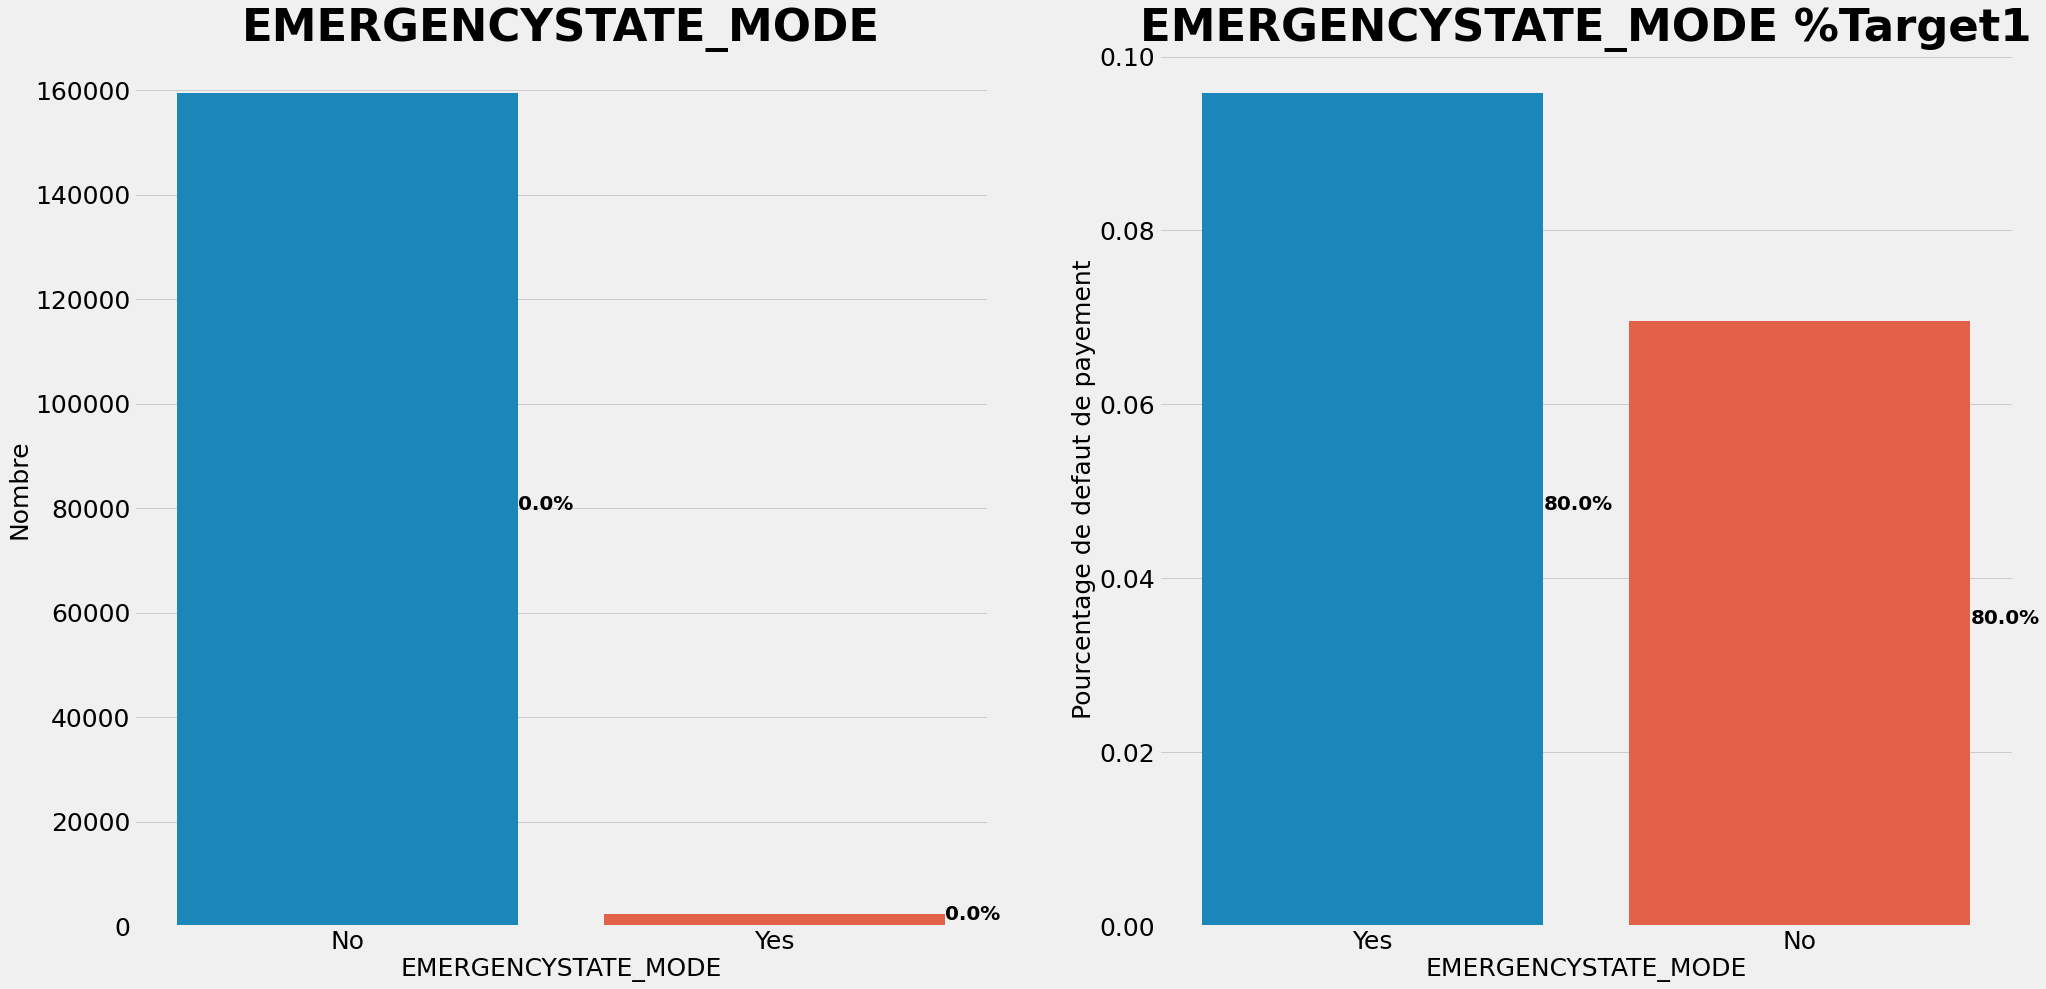

In [210]:
plot_stat(application_train, 'EMERGENCYSTATE_MODE',"EMERGENCYSTATE_MODE")

### <span style="color:#39ac39">3-5 Corrélations</span>

In [214]:
#Display correlations
print('Corrélations les plus positives:\n', application_train.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Corrélations les plus négatives:\n', application_train.corr()['TARGET'].sort_values().head(15))

Corrélations les plus positives:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
Corrélations les plus négatives:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_OUTLIERS       -0.045987
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLO

La corrélation linéaire la plus forte est celle de la variables "DAYS_BIRTH". Pour facilité la compréhension, les jours exprimés en valeurs négatives peuvent être traités en valeurs absolues. Dans ce cas, le coeficient de corrélation sera négative, cela expose le fait qu(un client plus âgé sera moins susceptible de faire défaut au remboursement de son crédit.

In [215]:
#Trouvez la corrélation entre les jours positifs depuis la naissance et la cible.
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982709

En termes de distribution des âges elle peut uniquement servir à visualiser la non présence d'outliers, suite à ce qui a été fait en amont sur les valeurs négatives de départ. Pour visualiser l'effet de l'âge sur la Target, nous pouvons faire un graphique (KDE) coloré par la valeur TARGET 0 et 1.

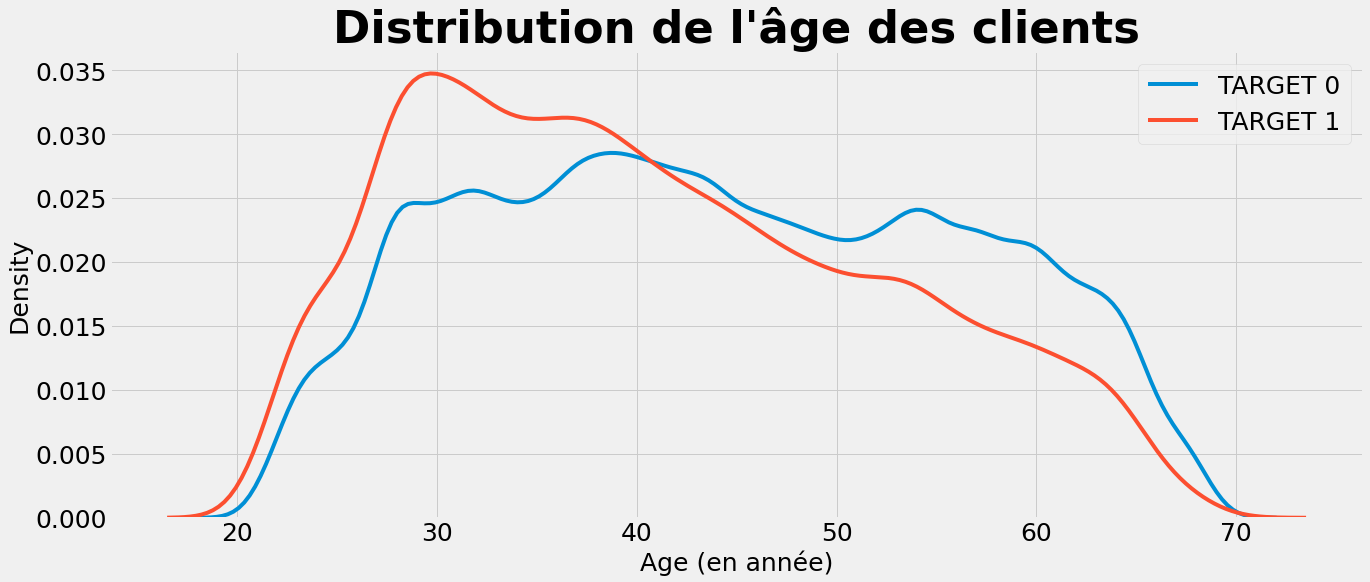

In [218]:
plt.figure(figsize = (20, 8))
sns.kdeplot(abs(application_train[application_train['TARGET'] == 0]['DAYS_BIRTH'] / -365), label = 'TARGET 0')
sns.kdeplot(abs(application_train[application_train['TARGET'] == 1]['DAYS_BIRTH'] / -365), label = 'TARGET 1')

plt.legend(), plt.xlabel('Age (en année)'), plt.ylabel('Density'), plt.title("Distribution de l'âge des clients")
plt.show()

La courbe cible TARGET 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient Pearson -0,07), cette variable sera probablement utile dans un modèle d'apprentissage car elle affecte la Target.

### <span style="color:#39ac39">3-6 Sources extérieures, les plus fortes corrélations linéaires</span>

Les 3 variables (EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3) présentant les corrélations linéaires négatives les plus fortes avec la Traget. Selon la documentation, ces fonctionnalités représentent un "score normalisé à partir d'une source de données externe". Difficile de comprendre le sens exact, nous pouvons émettre l'hypothèse d'une cote de crédit cumulative établie à l'aide de différentes sources de données.

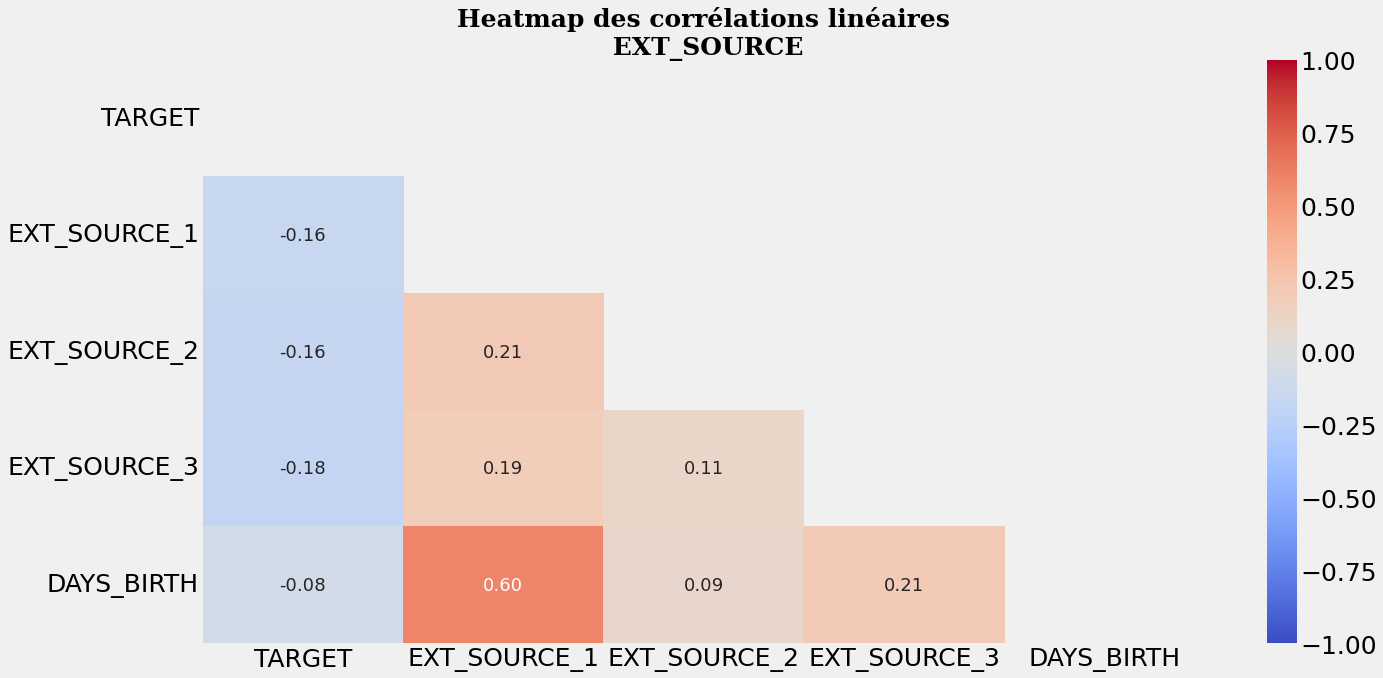

In [224]:
data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':18}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n EXT_SOURCE", fontdict=font_title)
plt.savefig("Figure18.png")
plt.show()

Ces sources extérieures sont corrélées négativement avec la Target (Attention, négativement mais avec de très faibles coefficients). Malgré tout, on peut penser que si la valeur augmente, le client est plus susceptible de pouvoir rembourser le crédit. Notons que 'DAYS_BIRTH' est corrélée avec 'EXT_SOURCE_1', peut-être l'un des facteurs de ce score est l'âge du client.

In [225]:
#Distribution d'une caractéristique
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = application_train.loc[application_train['TARGET'] == 0]
    t1 = application_train.loc[application_train['TARGET'] == 1]

    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    plt.show()   

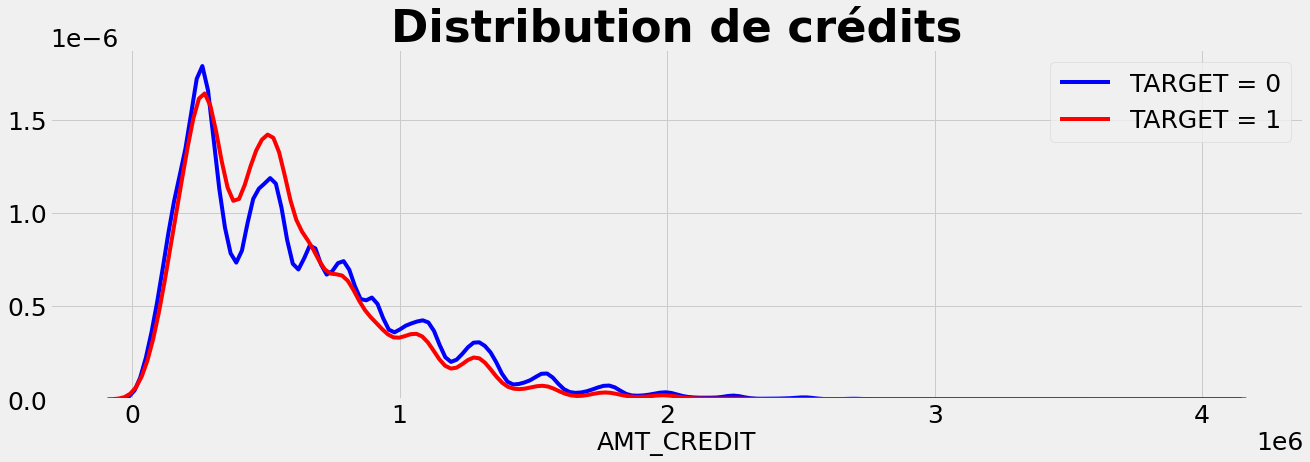

                                   -------------------------------------------------------


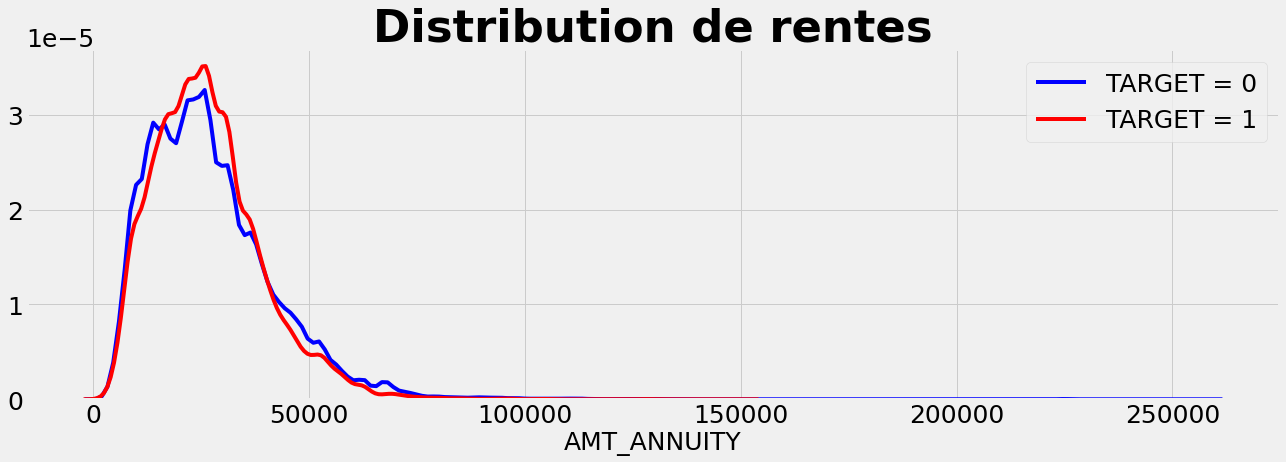

                                   -------------------------------------------------------


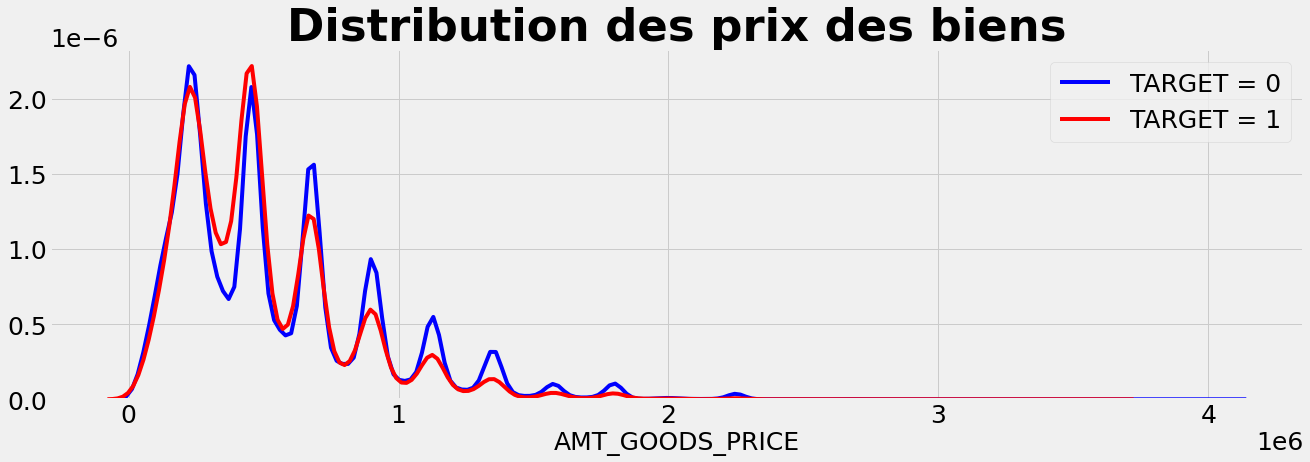

                                   -------------------------------------------------------


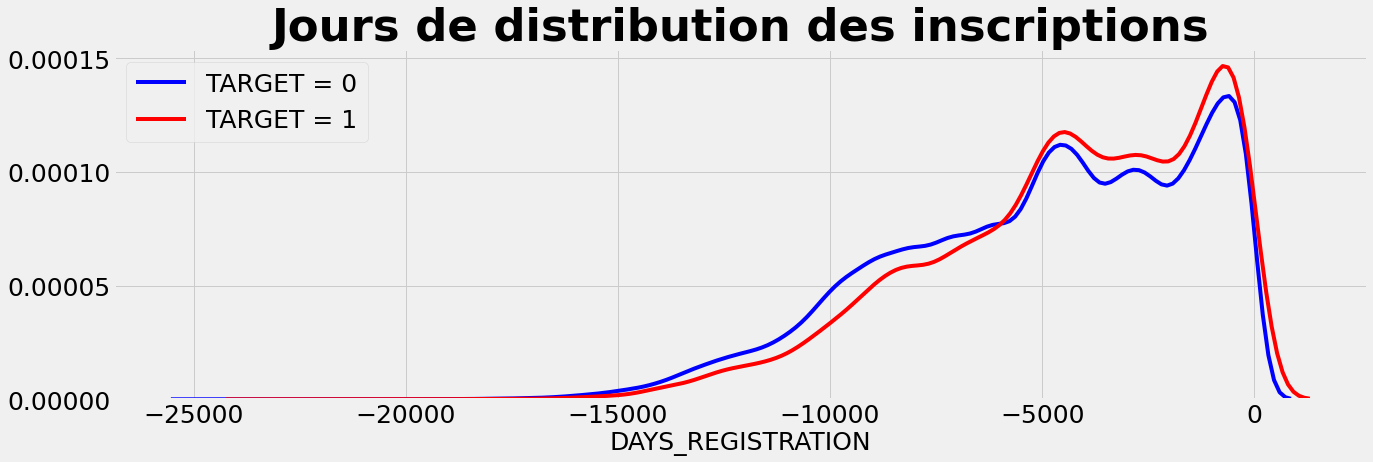

                                   -------------------------------------------------------


In [227]:
plot_distribution('AMT_CREDIT', "Distribution de crédits")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_ANNUITY', "Distribution de rentes")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_GOODS_PRICE', "Distribution des prix des biens")
print("                                   -------------------------------------------------------")
plot_distribution('DAYS_REGISTRATION', "Jours de distribution des inscriptions")
print("                                   -------------------------------------------------------")

## Fichier EDA bureau.csv

Ce fichier de données comporte tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au Bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).

Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

SK_ID_CURR est la clé reliant les données application_train | test aux données du bureau. Il est nécessaire de fusionner "application_train" avec "bureau" pour pour pouvoir extraire la part de TARGET == 1.

In [229]:
application_bureau_train = application_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
application_bureau_train.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100002       1         Cash loans           M            N   
2      100002       1         Cash loans           M            N   
3      100002       1         Cash loans           M            N   
4      100002       1         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
0               Y             0          202500.0    406597.5        24700.5   
1               Y             0          202500.0    406597.5        24700.5   
2               Y             0          202500.0    406597.5        24700.5   
3               Y             0          202500.0    406597.5        24700.5   
4               Y             0          202500.0    406597.5        24700.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1         351000.0   Unaccompanied          Working   
2         351000.0   Unaccompanied          Working   
3         351000.0   Unaccompanied          Working   
4         351000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1  Secondary / secondary special  Single / not married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special  Single / not married  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.018801        9461           -637            -3648.0   
2                    0.018801        9461           -637            -3648.0   
3                    0.018801        9461           -637            -3648.0   
4                    0.018801        9461           -637            -3648.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1            -2120          NaN           1               1                0   
2            -2120          NaN           1               1                0   
3            -2120          NaN           1               1                0   
4            -2120          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0        Laborers              1.0   
2                 1           1           0        Laborers              1.0   
3                 1           1           0        Laborers              1.0   
4                 1           1           0        Laborers              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     2                            2   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                  WEDNESDAY                       10   
2                  WEDNESDAY                       10   
3                  WEDNESDAY                       10   
4                  WEDNESDAY                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2            

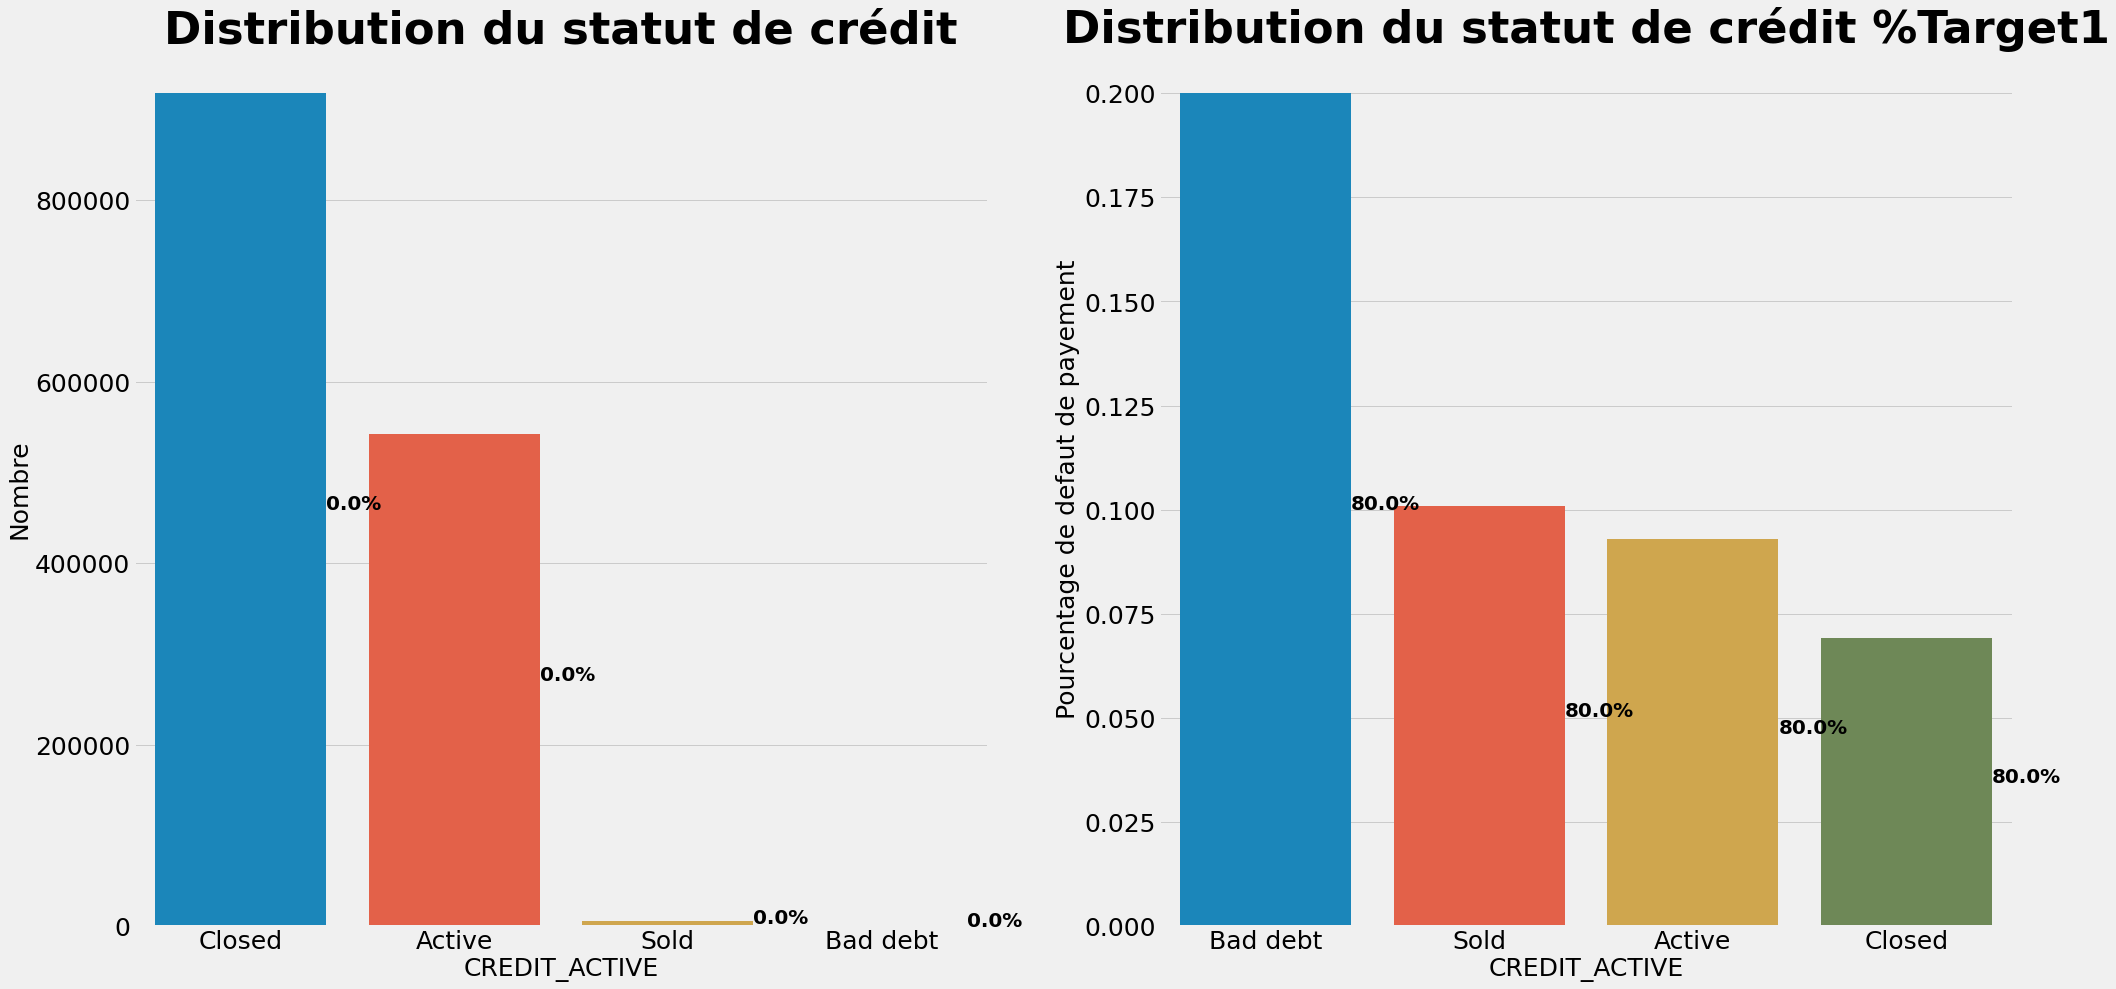

In [230]:
#CREDIT_ACTIVE
plot_stat(application_bureau_train, 'CREDIT_ACTIVE',"Distribution du statut de crédit")

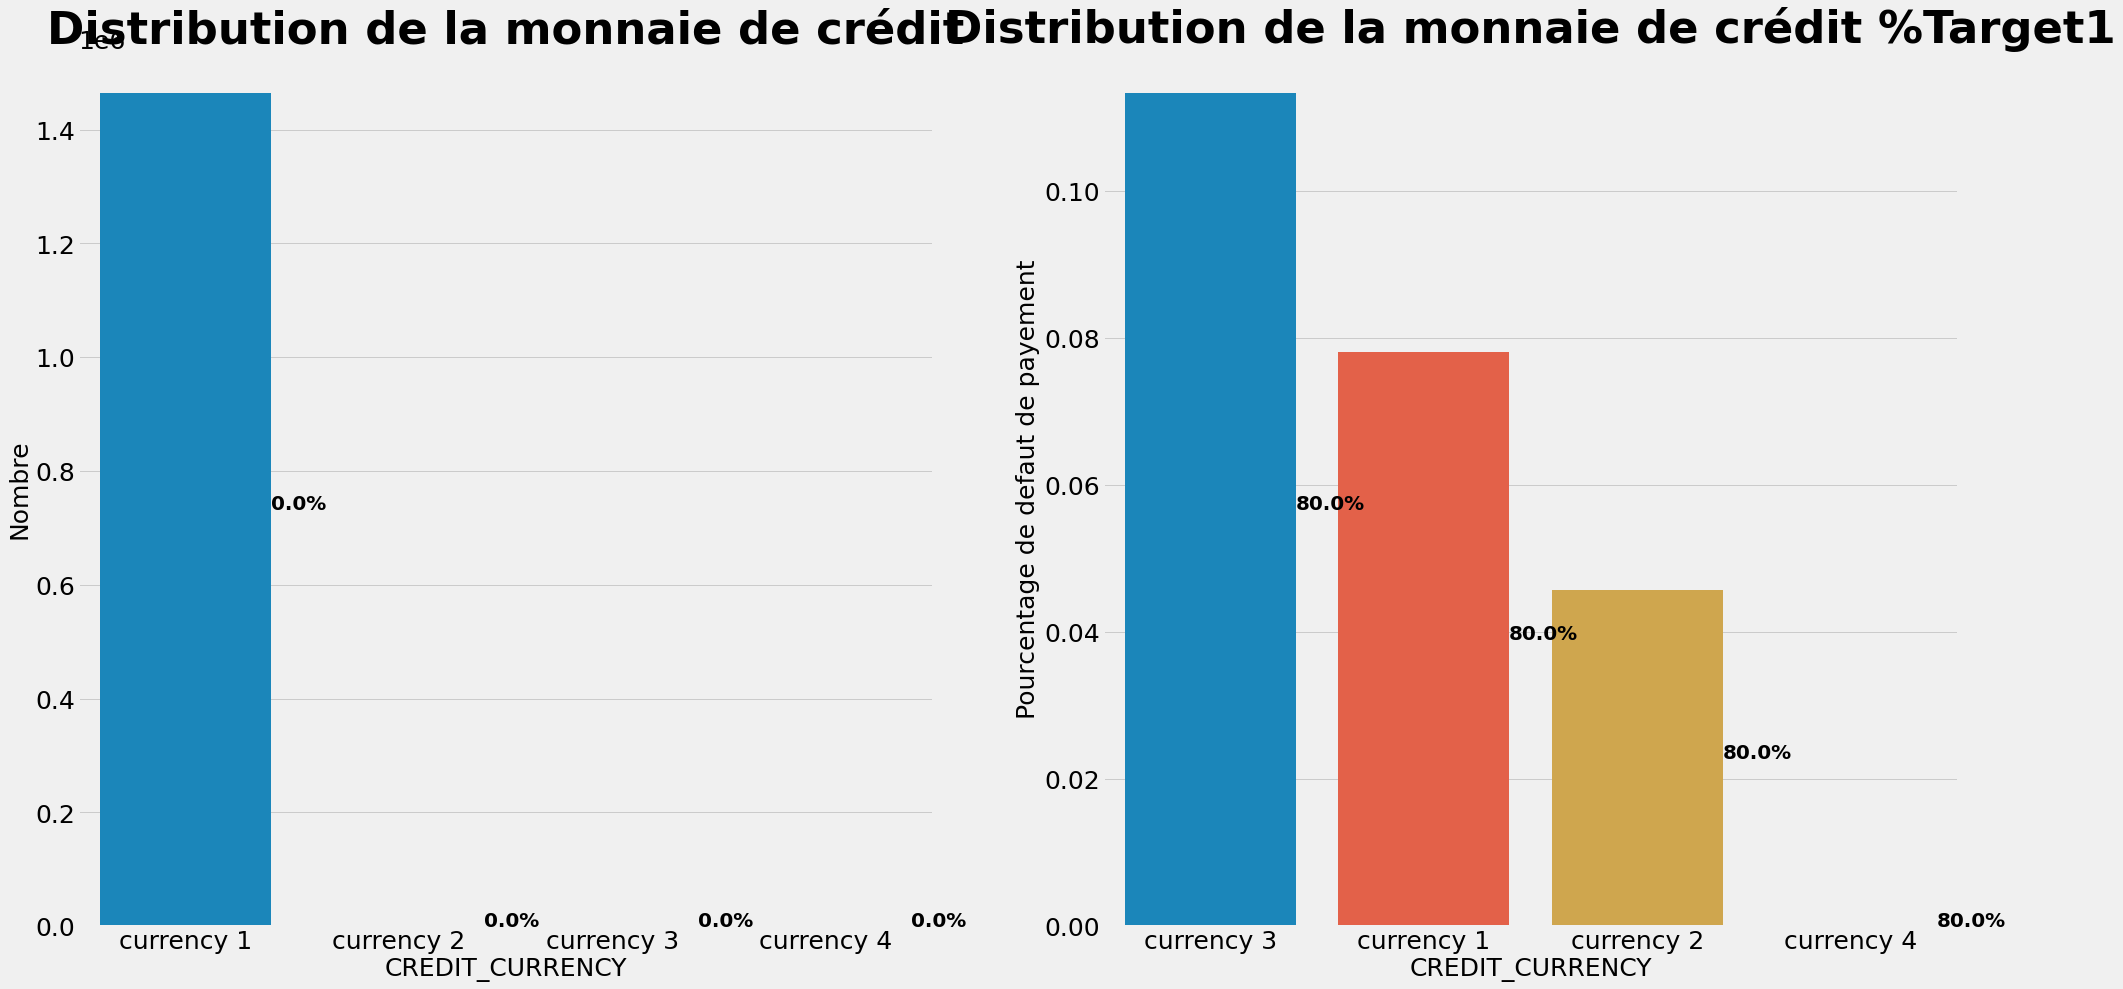

In [231]:
#CREDIT_CURRENCY
plot_stat(application_bureau_train, 'CREDIT_CURRENCY',"Distribution de la monnaie de crédit")

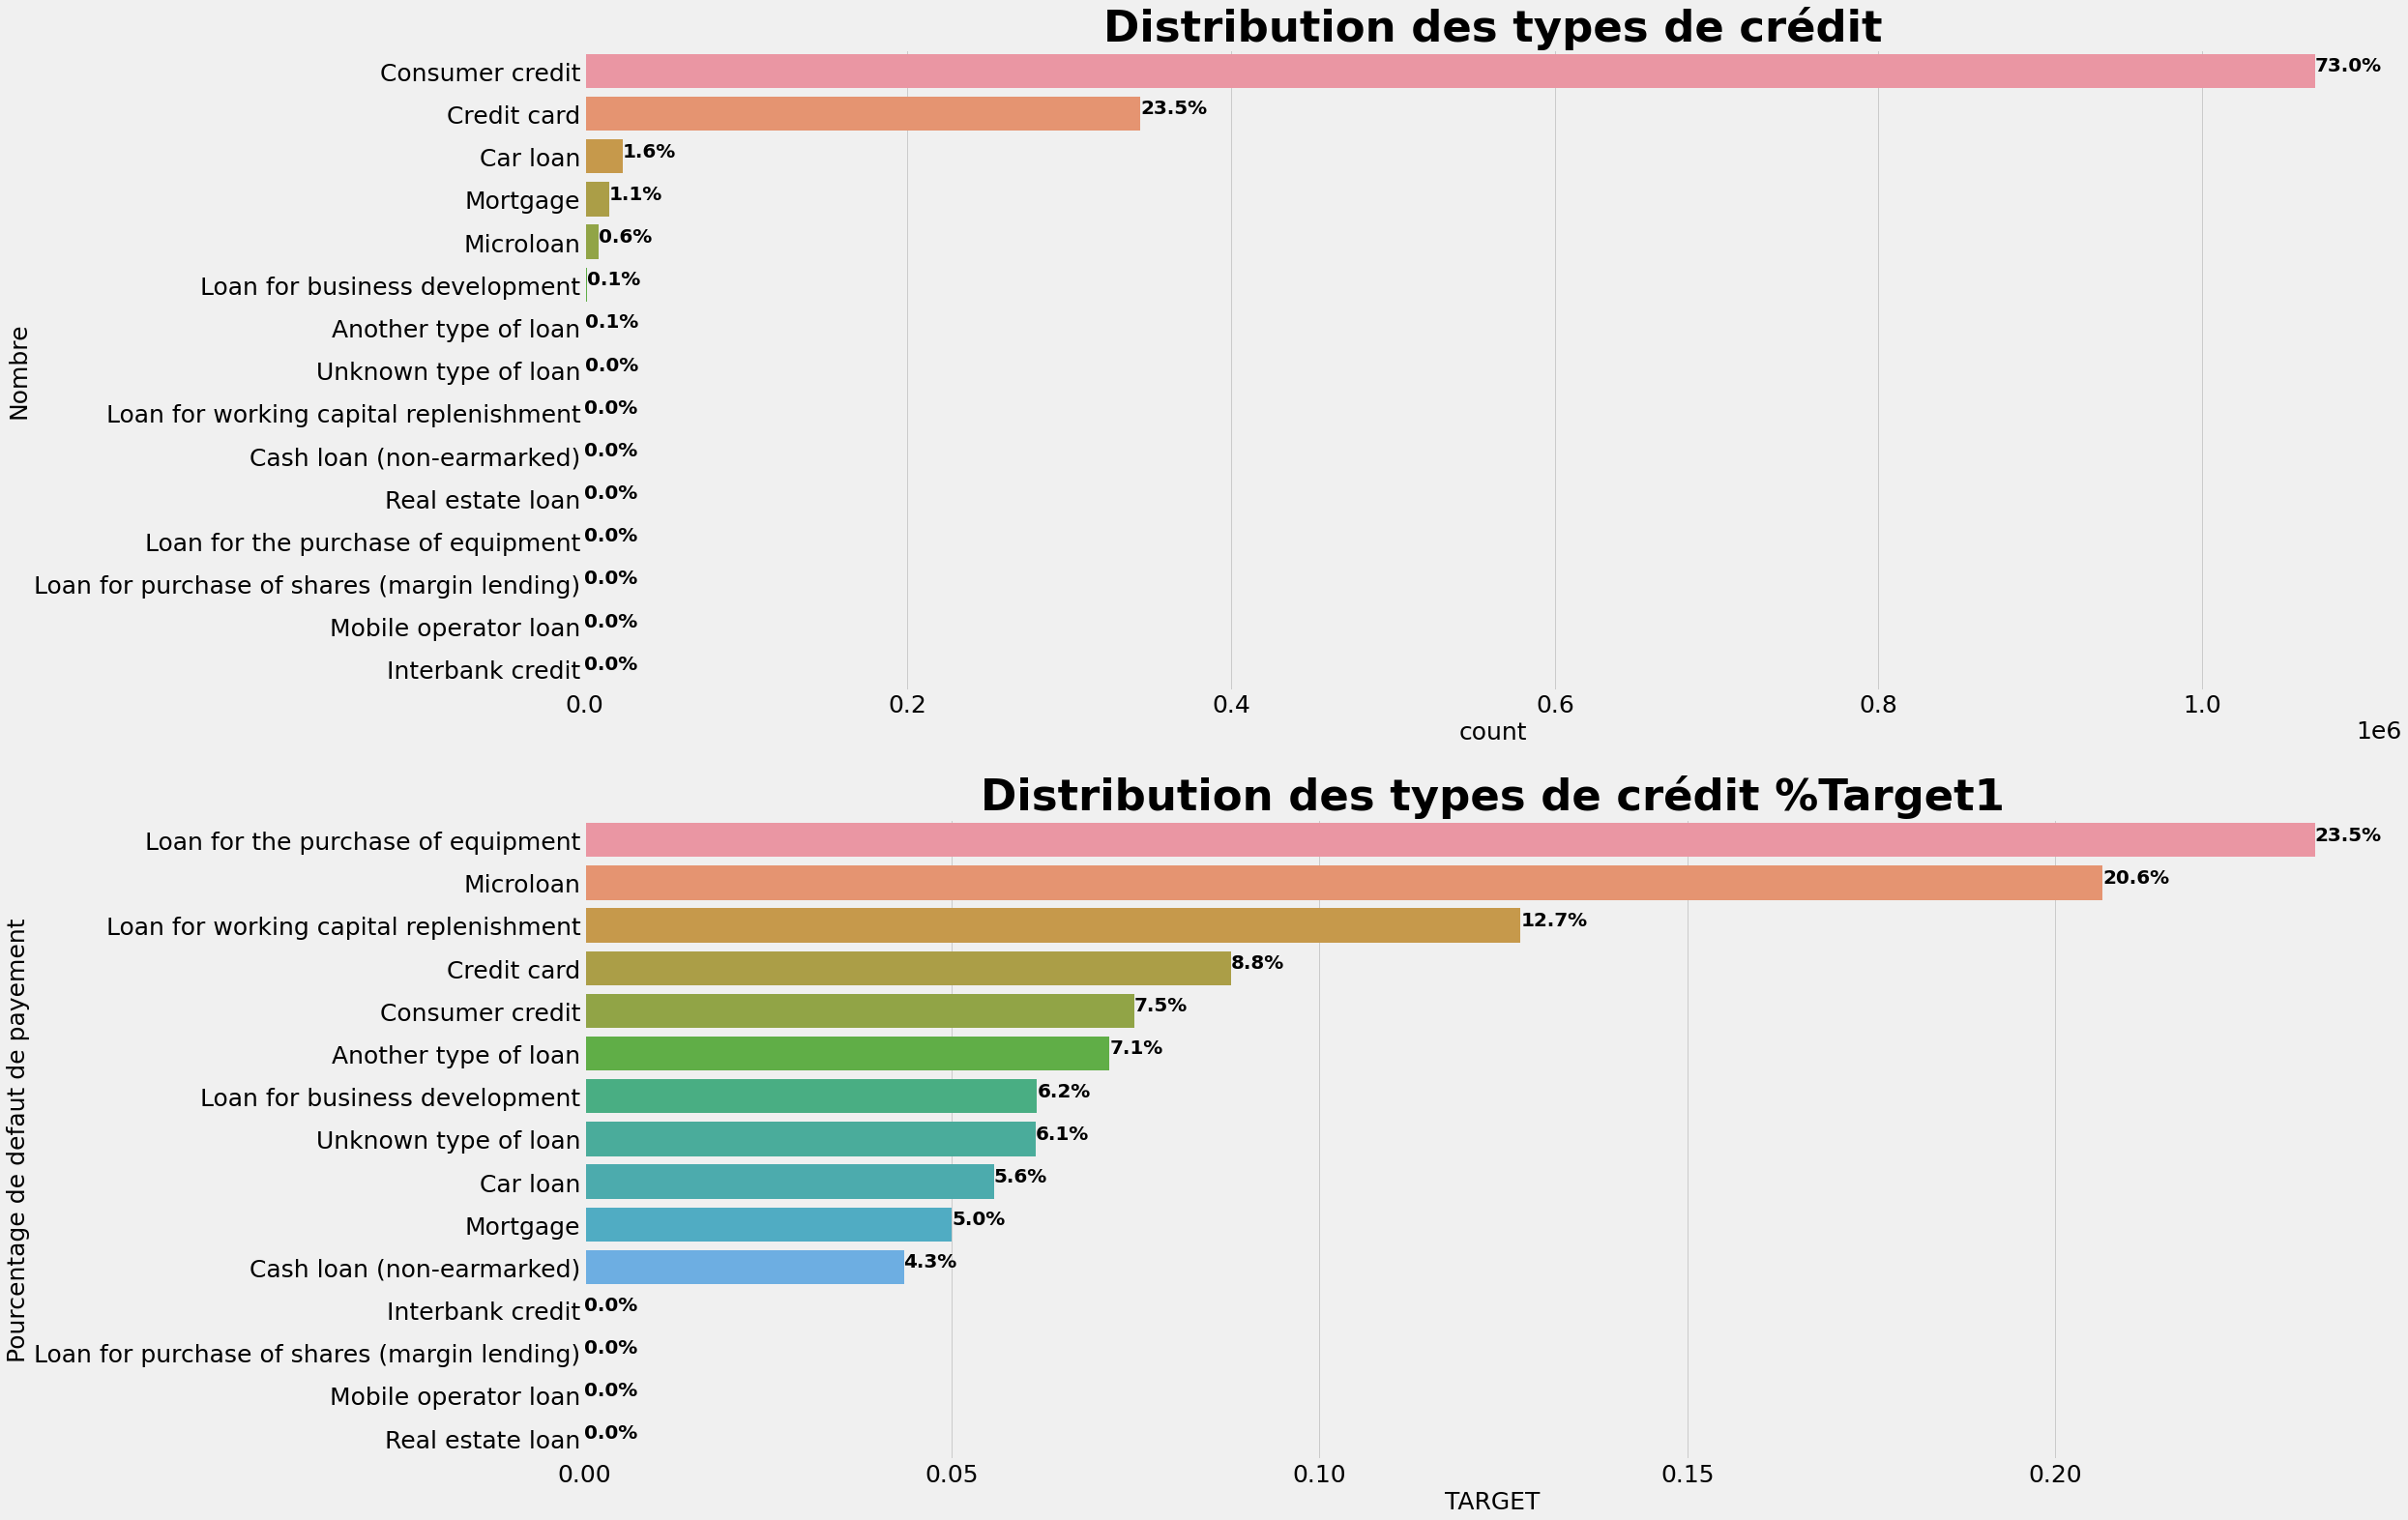

In [232]:
#CREDIT_TYPE
plot_stat2(application_bureau_train, 'CREDIT_TYPE',"Distribution des types de crédit")

In [ ]:
EDA previous_application.csv